# Assignment 2
### COMP9418 – Advanced Topics in Statistical Machine Learning


- Zhichao Yang z5133213
- Shurong Zhang z5203648
- Zhounan Wang z5179018

In [1]:
import re
import itertools
import random
import numpy as np
import pandas as pd

from abc import abstractmethod
from collections import OrderedDict as odict
from collections import defaultdict
from itertools import product
from graphviz import Digraph, Graph
from tabulate import tabulate
from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib as mpl

import sys, time

In [2]:
class GraphBase:
    def __init__(self, graph = defaultdict(list)):
        self.graph = graph
        
    def __getitem__(self, key):
        return self.graph[key] 
    
    def __iter__(self):
        return iter(self.graph)
    
    def __len__(self):
        return self.graph.__len__()
    
    def keys(self):
        return self.graph.keys()
    
    def items(self):
        return self.graph.items()

    def insert_node(self, node):
        self.graph[node] = []
        
    def remove_node(self, node):
        return self.remove_nodes(set([node]))
    
    def remove_nodes(self, nodes:set = set()):
        '''
        'nodes': a set of nodes
        '''
        #delete nodes
        G = self.graph
        children  = defaultdict(list)
        
        for n in nodes:
            children[n] = G[n]
            del G[n]
            
        for n in nodes:
            for i in G:
                if n in G[i]:
                    G[i].remove(n)
        return children
    
    def pop(self, key):
        return self.remove_node(self, key)
    
    def __delitem__(self, key):
        self.remove_node( key)
        
    @abstractmethod
    def connect_edge(self, node1, node2):
        '''
        add an edge from node1 to node2
        '''
        pass
    
    @abstractmethod
    def disconnect_edge(self, node1, node2):
        '''
        remove an edge from node1 to node2
        '''
        pass   

In [3]:
class DAG(GraphBase):
    
    def __init__(self, graph = defaultdict(list)):
        super(DAG, self).__init__(graph)
        
    def __setitem__(self, key,value):
        self.graph[key] = value
        return self

            
    def display_graph(self):
        g = self.graph
        dot = Digraph(engine="dot")
        for v in g.keys():
            dot.node(v)
        for v in g.keys():
            for w in g[v]:
                dot.edge(v, w)
        return dot
    
    def children(self, v):
        return self.graph[v]

    def generate_parents(self):
        self.reverse_graph = self._transpose_graph()
        
    def parents(self, v): 
        return self.reverse_graph[v]
    
    def __str__(self):
        return self.display_graph().__str__()
    
    def _repr_svg_(self):
        return self.display_graph()._repr_svg_()
                
    def connect_edge(self, node1, node2):
        '''
        add an edge from node1 to node2
        '''
        if node2 not in self.graph[node1]:
            self.graph[node1].append(node2)
    
    def disconnect_edge(self, node1, node2):
        '''
        remove an edge from node1 to node2
        '''
        if node2 in self.graph[node1]:
            self.graph[node1].remove(node2)
            
    def find_leaves(self, S:set = set()):
        '''
        find all leaves, except those in S
        '''
        leaves = set()
        
        for v in self.graph:
            if self.graph[v] == [] and v not in S:
                leaves.add(v)
                
        return leaves

    def transfor2UndirectedGraph(self):
        ugraph = deepcopy(self.graph)
        for i in self.graph:
            for j in self.graph[i]:
                #add a reserve edge
                ugraph[j].append(i)
        return UndirectedGraph(graph = ugraph)
    
    def _transpose_graph(self):
        G = self.graph
        GT = dict((v, []) for v in G)
        for v in G:
            for w in G[v]:
                if w in GT:
                    GT[w].append(v)
                else:
                    GT[w] = [v]
        return GT
    def transpose_graph(self):
        return DAG(self._transpose_graph())
    
    def _topologicalOrdering_r(self, v, colour, stack):
        colour[v] = 'gray'
        
        for w in self.graph[v]:
            if colour[w] == 'white':
                self._topologicalOrdering_r(w, colour, stack)
        stack.append(v)
        colour[v] = 'black'
        
    def topologicalOrdering(self):
        colour = {node:'white' for node in self.graph.keys()}
        stack = []
        for v in self.graph:
            if colour[v] == 'white':
                #using DFS find topological order
                self._topologicalOrdering_r(v, colour, stack)
        return list(reversed(stack))
                          

In [4]:
class UndirectedGraph(GraphBase):
    def __init__(self, graph = defaultdict(list)):
        super(UndirectedGraph, self).__init__(graph)

    def __setitem__(self, key,value):
        '''
        G[(A,B,C)] = [(C,D), (B,H)]
        '''
        self.graph[key] = value
        self.graph[value] = key
        return self
    

    
    def add_fill_in_edges(self, neighbors):
        for i in itertools.combinations(neighbors, 2):
            self.connect_edge(i[0], i[1])
    
    def remove_node_with_added_fill_in_edges(self, v):
        neighbors = self.graph[v]
        self.add_fill_in_edges(neighbors)
        self.remove_node(v)
        
    def neighbors(self, v):
        return self.graph[v]
    
    def degree(self, v):
        return len(self.neighbors(v))
    
    def min_degree_node(self):
        return min(self.graph, key = self.degree)
    
    def display_graph(self):
        g = self.graph
        dot = Graph(engine="dot")
        
        for v in g.keys():
            dot.node(v)
            
        already_display = set()
        for v in g.keys():
            already_display |= set([v])
            for w in g[v]:
                if w not in already_display:
                    dot.edge(v, w)
        return dot  
    
    def __str__(self):
        return self.display_graph().__str__()
    
    def _repr_svg_(self):
        return self.display_graph()._repr_svg_()
    
    def connect_edge(self, node1, node2):
        '''
        add an edge from node1 to node2
        '''
        if node2 not in self.graph[node1]:
            self.graph[node1].append(node2)
            self.graph[node2].append(node1)
    
    def disconnect_edge(self, node1, node2):
        '''
        remove an edge from node1 to node2
        '''
        if node1 in self.graph[node2]:
            self.graph[node1].remove(node2)
            self.graph[node2].remove(node1)

In [5]:
class FactorsBase:
    def __init__(self, outcome_space, factors = {}):
        self.outcome_space = outcome_space
        self.factors = factors
    
    def __getitem__(self, key):
        return self.factors[key]
    
    def __setitem__(self, key, value):
        self.factors[key] = value
        return self
    
    def __iter__(self):
        return iter(self.factors)
    
    def __len__(self):
        return self.factors.__len__()
    
    def __delitem__(self, key):
        del self.factors[key]
        
    def part_copy(self, keys:set()):
        temp = {}
        for i in keys:
            temp[i] = self.factors[i]
        return Factors(deepcopy(self.outcome_space), deepcopy(temp))
    
    def pop(self, key):
        return self.factors.pop(key)
    
    def keys(self):
        return self.__iter__()
    
    def values(self):
        return self.factors.values()
    def items(self):
        return self.factors.items()
    
    def get_factor(self, f):
        return self.factors[f]
    
    def get_factors(self):
        return self.factors
    
    def get_outcome_space(self):
        return self.outcome_space
    
    def add_factor(self, node, factor, outcom_space = None):
        '''
        add a factor to outcomespace and prob_table
        '''
        if outcom_space != None:
            self.outcome_space[node] = outcom_space
        
        self.factors[node] = factor
    def remove_factor(self, node):
        self.__delitem__(node)
        
    def remove_factors(self, nodes:set = set()):
        for i in nodes:
            self.remove_factor(i)
            
    def remove_outcome_space(self, node):
        del self.outcome_space[node]
        
    def remove_outcome_spaces(self, nodes):
        for i in nodes:
            self.remove_outcome_space(i)
        
    def update_factor(self , node, factor):
        '''
        update_factor doesn't update outcome_space
        '''
        self.factors[node] = factor
    
    def update_outcome_space(self, dom , value):
        self.outcome_space[dom] = value
    
    def rename_factor(self, old_factor, new_name):
        self.factors[new_name] = self.factors.pop(old_factor)
        
    def evidence(self, var, e):
        '''
        given evidence update outcome_space
        '''
        self.outcome_space[var] = (e,)
        
    def evidences(self, e:dict = {}):
        for i in e:
            self.evidence(i, e[i])
            
    def __generateRow(self, t, index, dom, outcomespace, row, new_row, prob, new_dom):
        if index == len(dom):
            prob.append((tuple(new_row), t[tuple(row)]))
            return
        for i in outcomespace[dom[index]]:
            row.append(i)
            if dom[index] in new_dom:
                new_row.append(i)
                
            self.__generateRow(t, index+1, dom, outcomespace, row, new_row, prob, new_dom)
            row.pop()
            if dom[index] in new_dom:
                new_row.pop()
                
    def __generateTable(self, t, dom, outcome_space, new_dom):
        row = []
        new_row = []
        prob = []
        self.__generateRow(t, 0, dom, outcome_space, row, new_row, prob, new_dom)
        factor = {'dom': tuple(new_dom), 
                      'table': odict(prob)}
        return factor
        
    def update_factor_given_evidence(self, f, new_outcome_space, new_dom_set:set):
        new_dom = []
        for i in self.factors[f]['dom']:
            if i in new_dom_set:
                new_dom += [i]
        return self.__generateTable(self.factors[f]['table'], self.factors[f]['dom'], new_outcome_space, new_dom)
    
    
    def update_factors_given_evidence(self, e:dict = {}, update_nodes:set = set()):
        S = set(e.keys())
        children = update_nodes
        
        outcome_space_before = deepcopy(self.outcome_space)
        #update outcome space
        self.evidences(e)
        # only the children which are given evidence need updated
        outcome_space_after = deepcopy(self.outcome_space)
        
        for c in children:
            new_dom_set = set(self.factors[c]['dom'])
            new_dom_set = new_dom_set-((new_dom_set & S) -set(c))
            
            #using list to keep order of new_dom  
            outcome_space_after[c] = outcome_space_before[c]
            #update prob table
            self.factors[c] = self.update_factor_given_evidence(c, outcome_space_after, new_dom_set)
            outcome_space_after[c] = self.outcome_space[c]
             
    def to_tabulate(self, f):
        """
        argument
        `f`, a factor to print on screen
        """
        # Create a empty list that we will fill in with the probability table entries
        table = list()

        # Iterate over all keys and probability values in the table
        for key, item in self.factors[f]['table'].items():
            # Convert the tuple to a list to be able to manipulate it
            k = list(key)
            # Append the probability value to the list with key values
            k.append(item)
            # Append an entire row to the table
            table.append(k)
        # dom is used as table header. We need it converted to list
        dom = list(self.factors[f]['dom'])
        # Append a 'Pr' to indicate the probabity column
        dom.append('Pr')
        return tabulate(table, headers=dom, tablefmt='orgtbl')
    
    def print_factor(self, f):
        """
        argument
        `f`, a factor to print on screen
        """
        print(self.to_tabulate(f))
        print()
            
    def print_all_factor(self):
        for i in self.factors:
            self.print_factor(i)
    
    def print_outcome_space(self, f):
        print(self.outcome_space[f])
    
    def print_all_outcomeSpace(self):
        print(self.outcome_space)
        
    def get_value(self, f, *entry):
        """
        argument 
        `factor`, a dictionary of domain and probability values,
        `entry`, a list of values, one for each variable in the same order as specified in the factor domain.

        Returns p(entry)
        """
        return 1 if entry == () else float(f['table'][entry])    
    
    def __repr__(self):
        return '\n\n'.join([f'{f} :\n' + self.to_tabulate(f).__str__() for f in self.factors.keys()])
    
    def join(self, f1, f2):
        #update new domain
        new_dom = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
        table = []
        
        for entries in product(*[self.outcome_space[v] for v in new_dom]):
            entry_dict = dict(zip(new_dom, entries))
            #calculate the key of f1 and f2
            f1_entry = (entry_dict[var] for var in f1['dom'])
            f2_entry = (entry_dict[var] for var in f2['dom'])
            
            #using the key to find the probability of f1 and f2
            p1 = self.get_value(f1, *f1_entry)
            p2 = self.get_value(f2, *f2_entry)

            table.append((entries, p1 * p2))
        return {'dom': tuple(new_dom), 'table': odict(table)}
   

    def product(self, f1_name, f2_name):
        '''
        f1_name, f2_name are the name of factors(key)
        '''
        f1 = self.factors[f1_name]
        f2 = self.factors[f2_name]

        return self.join(f1, f2)
    
    

In [6]:
class Factors(FactorsBase):
    '''
    if the probability table is a join probability, then we can use Factors directly, but CPT does not
    '''
    def __init__(self, outcome_space, factors = {}):
        super(Factors, self).__init__(outcome_space, factors)
        
    def partition_function(self, f):
        return sum(float(i) for i in f['table'].values())
    
    def normalize(self, f = None, outside_f = None):
        f = self.factors[f] if outside_f == None else outside_f
        Z = self.partition_function(f)
        for i in f['table']:
            f['table'][i] = str(float(f['table'][i])/Z)
            
        return f
            
    def _marginalize(self, var,f):
        """
        argument 
        `f`, factor to be marginalized.
        `var`, variable to be summed out.
        `outcomeSpace`, dictionary with the domain of each variable

        Returns a new factor f' with dom(f') = dom(f) - {var}
        """ 
        factor = f
        new_dom = list(factor['dom'])
        
        #update domain
        new_dom.remove(var)
        
        #update table
        table = []
        
        i = factor['dom'].index(var)
        for entries in itertools.product(*[self.outcome_space[i] for i in new_dom]):
            table.append((entries, sum([factor['table'][tuple(list(entries[:i]) + [v] + list(entries[i:]))] for v in self.outcome_space[var]])))
        return {'dom': tuple(new_dom), 'table': odict(table)}

    def marginalize(self, var_s:set, f):
        for  i in var_s:
            #only i in domain, we do marginalize operation
            if i in f['dom']:#for jointree the table may not contain all item, just a subset of coresponding node
                f = self._marginalize(i, f)
        return f

In [7]:
class CPTs(FactorsBase):
    '''
    This class is the representation of conditional probibality table
    The factor may not sum up to 1
    The probabilities of CPTs 
    '''
    def __init__(self, outcome_space, factors):
        super(CPTs, self).__init__(outcome_space, factors)
        
    def prob(self, f, *entry):
        """
        argument 
        `factor`, a dictionary of domain and probability values,
        `entry`, a list of values, one for each variable in the same order as specified in the factor domain.

        Returns p(entry)
        """
        return self.get_value(f, *entry)
    
    def to_cluster_factor(self):
        cluster_factor = defaultdict(dict)
        for i in self.factors:
            cluster_factor[Cluster(self.factors[i]['dom'])] = self.factors[i]
        return cluster_factor

In [8]:
class Message:
    def __init__(self, start, end):
        self.value = ((start), (end))
        
    def __iter__(self):
        return iter(self.value)
    
    def __repr__(self):
        return str(self.value)
    
    def __eq__(self, x):
        return self.value == x.value
    
    def __ne__(self, x):
        return not self.__eq__(x)
    
    def __hash__(self):
        '''
        make sure the Cluster is hashable
        '''
        return hash(self.value)

In [9]:
class Cluster:
    def __init__(self, value:tuple):
        self.value = tuple(value)
    
    def __setattr__(self, name, value):
        if name == "value":
            value = tuple(sorted(value))
        self.__dict__[name] = value
        
    def __iter__(self):
        return iter(self.value)
    def __repr__(self):
        return str(self.value)
    
    def __eq__(self, x):
        if isinstance(x, tuple):
            return self.value == tuple(sorted(x))
        return self.value == x.value
    
    def __ne__(self, x):
        return not self.__eq__(x)
    
    def __le__(self, x):
        '''
        this means x.value is the subset of self.value or x.value is self.value
        '''
        return self.value == x.value or set(x.value) == (set(self.value) | set(x.value))
    
    def __ge__(self, x):
        '''
        this means x.value is the subset of self.value or x.value is self.value
        '''
        return self.value == x.value or set(self.value) == (set(self.value) | set(x.value))
    def __or__(self, x):
        return Cluster(set(self.value) |set(x.value))
    
    def __and__(self, x):
        return Cluster(set(self.value) & set(x.value))
    
    def __sub__(self, x):
        return Cluster(set(self.value) - set(x.value))
    
    def __lshift__(self, x):
        return Message(x, self)
    
    def __rshift__(self, x):
        return Message(self, x)
    
    def __hash__(self):
        '''
        make sure the Cluster is hashable
        '''
        return hash(self.value)

In [10]:
class ClusterGraph:
    '''
    Because the isolated nodes can not appear in jointree, therefore, the ClusterGraph doesn't inherit GraphBase
    
    ClusterGraph is a graph which all node belong to class Cluster
    
    '''
    def __init__(self, graph = defaultdict(list)):
        self.graph = graph
        
    def __getitem__(self, key):
        return self.graph[key] 
    
    def __iter__(self):
        return iter(self.graph)
    
    def __len__(self):
        return self.graph.__len__()
    
    def keys(self):
        return self.graph.keys()
    def values(self):
        return self.graph.values()
    
    def items(self):
        return self.graph.items()
    
    def neighbors(self, v):
        return self.graph[v]
    
    def degree(self, v):
        return len(self.neighbors(v))
    
#     def min_degree_of_node(self):
#         return min(self.graph, key = self.degree)
    
    def get_num_edges(self):
        return sum(self.degree(v) for v in self.graph)/2
    
    def display_graph(self):
        def node2str(node):
            return ','.join(node)
        
        g = self.graph
        dot = Graph(engine="dot")
        
        for v in g.keys():
            dot.node(node2str(v))
            
        already_display = set()
        for v in g.keys():
            already_display |= set([v])
            for w in g[v]:
                if w not in already_display:
                    dot.edge(node2str(v), node2str(w))
        return dot  
    
    def pop(self, key):
        return self.remove_node(self, key)
    
    def __delitem__(self, key):
        self.remove_node(self, key)
        
    def __str__(self):
        return self.display_graph().__str__()
    
    def _repr_svg_(self):
        return self.display_graph()._repr_svg_()
    
    def _insert_node(self, node):
        self.graph[node] = []
        
    def _remove_node(self, node):
        return self.remove_nodes(set([node]))
    
    def _remove_nodes(self, nodes:set = set()):
        '''
        nodes should be a set
        '''
        #delete nodes
        G = self.graph
        children  = defaultdict(list)
        
        for n in nodes:
            children[n] = G[n]
            del G[n]
            
        for n in nodes:
            for i in G:
                if n in G[i]:
                    G[i].remove(n)
        return children
    
    def _update_node(self, old_cluster:list, new_cluster:Cluster):
        for i in old_cluster:
            self.graph[new_cluster] += self.graph.pop(i)
        for i in self.graph:
            for j in old_cluster:
                if j in self.graph[i]:
                    self.graph[i][self.graph[i].index(j)] = new_cluster
                
    def cluster_node_rename(self, old_cluster:Cluster, new_name:Cluster):
        self._update_node([old_cluster], new_name)
        
    def cluster_node_merge(self, cluster_n1:Cluster, cluster_n2:Cluster):
        self._update_node([cluster_n1, cluster_n2], cluster_n1 | cluster_n2)
        
    def connect_edge(self, node1, node2):
        '''
        add an edge from node1 to node2
        '''
        if node2 not in self.graph[node1]:
            self.graph[node1].append(node2)
            self.graph[node2].append(node1)
    
    def disconnect_edge(self, node1, node2):
        '''
        remove an edge from node1 to node2
        if the degree of node1 or node2 is 0, the node should be removed 
        '''
        if node1 in self.graph[node2]:
            self.graph[node1].remove(node2)
            if self.degree(node1) == 0:
                del self.graph[node1]
                
            self.graph[node2].remove(node1)
            if self.degree(node2) == 0:
                del self.graph[node2]      
        

In [11]:
class JoinTree:
    def __init__(self, cluster_graph:dict = {}, factors: Factors = None):
        self.cluster_graph = cluster_graph
        self.factors = factors
        self.evidence_indicater = None
        #store all information during query
        self.query = {}
        self.query['root'] = self.find_root(Cluster(tuple()))
        
    def __repr__(self):
        return self.factors.__repr__()
    
    
    #question 3
    def evidence(self, evi:dict = {}):
        '''
        should be implemented before query and get_message
        '''
        for e in evi:
            if evi[e] not in self.factors.outcome_space[e]:
                raise Exception(f'Invald evidence the {e}:{evi[e]} is not in outcome_space')
        lambdas = dict()
        for v,e in evi.items():
            if v in self.factors.get_outcome_space():
                lambdas[v] = dict()
                lambdas[v]['dom'] = (v,)
                lambdas[v]['table'] = odict(((i,), int(evi[v] == i)) for i in self.factors.get_outcome_space()[v])
        self.query['evidence'] = {Cluster(()): {'dom': tuple(), 'table': odict()}} if lambdas == {} else lambdas
        return self.query['evidence']
    
    def display_evidence(self):
        Factors(self.factors.get_outcome_space() , self.query['evidence']).print_all_factor()
        
    def have_evidence(self):
        '''
        If evidence have already been set, return True
        '''
        return self.query['evidence'] is not None
    
    #question 4
    #the user can find_root automatically
    #     the step of query
    #     1. set evidence
    #     2. get_message
    #     3. query
    def find_root(self, query_part:Cluster):
        '''
        find a node, where query_part is the subset of it
        if the node does not exist, raise an Exception
        '''
        for c in self.cluster_graph:
            if query_part <= c:
                self.query['root'] = c
                self.query['query'] = query_part
                break
        else:
            raise Exception("There is not a legal node")
        return self.query['root']
            
            
            
    def set_root(self, query_part:Cluster, root:Cluster):
        '''
        user set root, if the root is not valid, raise Exception
        '''
        if query_part <= root and root in self.cluster_graph:
            self.query['root'] = root
            self.query['query'] = query_part
        else:
            raise Exception("Invalid root")
        self.query['root']
        
    def _eliminate_evidence(self, f, root:Cluster):
        for i in root:
            if i in self.query['evidence']:
                f = self.factors.join(self.query['evidence'][i], f)
        return f
          
    def _pull(self, root:Cluster, previous:Cluster):
        fx = self.factors[root]
        #evidence elimination
        fx = self._eliminate_evidence(fx, root)
        for i in self.cluster_graph[root]:
            if not i == previous:
                #receive the message from children
                self.query['message'][i >> root] = self._pull(i, root)
                #update factor
                fx = self.query['message'].join(self.query['message'][i >> root], fx)
        #marginalize variables which are not in seperator
        fx = self.query['message'].marginalize(root - previous, fx)
        return fx
        
    def _push(self, root:Cluster, previous:Cluster = Cluster(())):
        for i in self.cluster_graph[root]:
            if i != previous:
                #eliminate evidence
                self.query['message'][root >> i] = self._eliminate_evidence(self.factors[root], root)
                #join with message push form previous
                if previous == Cluster(()):#it is root
                    for j in self.cluster_graph[root]:
                        if i != j:
                            self.query['message'][root >> i] = self.query['message'].join(self.query['message'][root >> i], self.query['message'][j >> root])
                else: #it is not root
                    self.query['message'][root >> i] = self.query['message'].join(self.query['message'][root >> i], self.query['message'][previous >> root])
                #marginalize var not in seperator
                self.query['message'][root >> i] = self.query['message'].marginalize(root - i, self.query['message'][root >> i])
                
                self._push(i, root)
        
    def get_message(self, root:Cluster = None):
        root = self.query['root'] if root == None or root not in self.cluster_graph else root
        self.query['message'] = Factors(self.factors.outcome_space, {}) #create an empty Factor class
        #pull messagee from children
        for v in self.cluster_graph[root]:
            self.query['message'][v >> root] =  self._pull(v, root)
        #push message to children
        self._push(root)
        return self.query['message']
            
    def clusters_query(self, var:set, query_root:Cluster = None, update_message = False, need_normalize = True):
        '''
        The evidence should be set on evidence function
        before query, both function evidence, get_message should be run
        or set update_message = Ture, the message will be updated
        '''
        for i in var:
            if i in self.query['evidence']:
                raise Exception(f"The var {i} has already be set as evidence {self.query['evidence'][i]}")
            
        #find root
        if query_root == None:
            self.find_root(Cluster(var))
        else:
            self.set_root(Cluster(var), query_root)
        
        if update_message == True:
            self.get_message(evi)
            
        fx = self._eliminate_evidence(self.factors[self.query['root']], self.query['root'])
        #join to multiply the incomming message from all nodes but v
        for i in self.cluster_graph[self.query['root']]:
            fx = self.factors.join(fx, self.query['message'][i >> self.query['root']])
        #fx is join distribution of all variable of root
        #marginalize remove variables in root but not in var
        fx = self.factors.marginalize(self.query['root'] - Cluster(var), fx)
        
        return self.factors.normalize(outside_f = fx) if need_normalize == True else fx
    
    def query_clear(self):
        '''
        after query, if user wants to start a new query,
        clear the history information 
        '''
        self.query = {}
        self.query['root'] = self.find_root(Cluster(tuple()))
        
        
    #question 5
    def add_a_variable(self, var, cluster_node:Cluster):
        '''
        var must appear in neighbors 
        '''
        if cluster_node not in self.cluster_graph:
            return
        if any([Cluster(var) <= cn for cn in self.cluster_graph.neighbors(cluster_node)]):
            #update graph
            self.cluster_graph.cluster_node_rename(cluster_node, cluster_node | Cluster(var))
            #update factors
            self.factors.rename_factor(cluster_node, cluster_node | Cluster(var))
        else:
            raise Exception('Invalid Variable, the variable does not exist in the neighbors of cluster node')
    
    def merge_clusters(self, cluster_n1, cluster_n2):
        '''
        cluster_n1, cluster_n2 must be neighbourhood
        '''
        if cluster_n1 not in self.cluster_graph or cluster_n2 not in self.cluster_graph:
            return
        new_cluster = cluster_n1 | cluster_n2
        if cluster_n1 in self.cluster_graph.neighbors(cluster_n2):
            #merge node in graph, all edges of n1 and n2 should connenct to the new node
            self.cluster_graph.cluster_node_merge( cluster_n1, cluster_n2)
            #merge factor in factors
            self.factors[new_cluster] = self.factors.join(self.factors.pop(cluster_n1), self.factors.pop(cluster_n2)) 
        else:
            raise Exception('Invalid cluster_node, the cluster_node is not a neighbour of old_cluster_node')
        
    
    def add_a_cluster(self, cluster_node:Cluster, old_cluster_node:Cluster):
        if old_cluster_node not in self.cluster_graph:
            return        
        if cluster_node <= old_cluster_node:
            #add cluster_node which connect with old_cluster_node
            self.cluster_graph.connect_edge(cluster_node, old_cluster_node)
            #add an empty table in factors
            self.factors[cluster_node] = {'dom': (), 'table': odict()}
        else:
            raise Exception('Invalid cluster_node, the cluster_node is not a subset of old_cluster_node')
    
    def remove_a_cluster(self, cluster_node:Cluster):
        '''
        the cluster node Ci can be removed only if it has a single neighbour Cj and 
        Ci belongs to Cj
        '''
        if cluster_node not in self.cluster_graph:
            return   
        neighbour = self.cluster_graph.neighbors(cluster_node)[0]
        if self.cluster_graph.degree(cluster_node) == 1 and neighbour >= cluster_node:
            #remove node and edge in graph
            self.cluster_graph.disconnect_edge(cluster_node, neighbour)
            #update factor, merge factor to its neighbour
            self.factors[neighbour] = self.factors.product(cluster_node, neighbour)
            del self.factors[cluster_node]
        else:
            raise Exception('Invalid cluster_node, the cluster_node is not equal to 1')
        

In [12]:
class BayesianNet:
    def __init__(self, path:str = "", graph:DAG = None, cpts: CPTs = None):
        if path == "":
            self.graph = graph
            self.cpts = cpts
        else:
            self.graph, self.cpts = self.load_BN(path)
            
    
    def insert_node(self, node, parents:list, cpt, outcome_space = None):
        '''
        If there are some new variables in new node, the coresponding outcome_space also should be updated
        Insert one node, should give all parents
        '''
        self.graph.insert_node(node)
        for p in parents:
            self.graph.connect_edge(p, node)
            
        self.cpts.add_factor(node, cpt, outcome_space)
            
        
    def remove_node(self, node, cpts = None):
        '''
        once removing a node, The new distribution of all children should be given
        '''
        children = self.graph[node]
        self.graph.remove_node(node)
        self.cpts.remove_factor(node)
        self.cpts.remove_outcome_space(node)
        for i in children:
            self.cpts.update_factor(i, cpts[i])
            
    def update_factor_in_a_node(self, node, cpt):
        '''
        update does not change the structure of BN, just update factor
        '''
        if sorted(self.cpts[node]['dom']) == sorted(cpt['dom']):
            self.cpts[node] = cpt
        
    def insert_edge(self, edge,  cpt):
        '''
        The node of both side should exist in the graph
        edge should be a tuple (A, B) A -> B
        cpt: user should give the new cpt of B
        '''
        if edge[0] in self.graph.keys() and edge[1] in self.graph.keys():
            self.graph.connect_edge(edge[0], edge[1])
            self.cpts.update_factor(edge[1], cpt)
        else:
            raise Exception("The edge is invalid")            
    
    def remove_edge(self, edge, cpt):
        '''
        The node of both side should exist in the graph
        edge should be a tuple (A, B) A -> B
        cpt: user should give the new cpt of B
        '''
        if edge[0] in self.graph.keys() and edge[1] in self.graph.keys():
            self.graph.disconnect_edge(edge[0], edge[1])
            self.cpts.update_factor(edge[1], cpt)
        else:
            raise Exception("The edge is invalid")      
        
        
    def get_outcom_space(self):
        return self.cpts.outcome_space
    
    def get_cpt(self, cpt_name):
        return self.cpts.get_factor(cpt_name)
    
    def get_cpts(self):
        return self.cpts
    
    def get_graph(self):
        return self.graph
    
    def __repr__(self):
        return self.cpts.__repr__()
    
    def pruning_nodes(self, q:set = set(), e: set = set()):
        S = q | e
        stop = False
        while(not stop):
            #1. find and delete leaves
            leaves = self.graph.find_leaves(S)
            stop = True if leaves == set() else False
            self.graph.remove_nodes(leaves)
            
            #2. remove coresponding prob table and outcome space
            self.cpts.remove_factors(leaves)
            self.cpts.remove_outcome_spaces(leaves)
            
        return self     
    
    def pruning_edges(self, e: dict = {}):
        #update tables given evidence
        
        children = set()
        # find children of evidence, which need be updated
        for i in e:
            children |= set(self.graph[i])
        children = children   
        #update prob_table
        self.cpts.update_factors_given_evidence(e, children)
        
        #delete all edges which in e
        for i in e:
            self.graph[i] = []
        
    def pruning_net(self, q:set = set(), e: dict = {}):
        '''
        BN G and a query(q, e)
        pruning nodes
            * can remove any leaf node as long as it does not belong to (q & e)
            * can be applied iteratively, possibly removing many nodes
        pruning edges
            * remove each edge U -> X, which originates from a node U belongs to E
            * replace the CPT p(X|U) by a smaller CPT instanced with e
        pruning net = pruning node + pruning edges
        '''
        #1. deep copy a bn class
        bn = deepcopy(self)
        # 2. pruning nodes
        bn.pruning_nodes(q, set(e.keys()))
        # 3. pruning edges
        bn.pruning_edges(e)
        
        return bn

    def moralize(self):
        '''
        BN moralized
        1. DAG -> undirected graph
        2. add edges for v structure(BN)
        '''
        self.moralized_graph = self.graph.transfor2UndirectedGraph()
        self.graph.generate_parents()
        
        for i in self.graph:
            for j in itertools.combinations(self.graph.parents(i), 2):
                self.moralized_graph.connect_edge(j[0], j[1])
        return self.moralized_graph
    
    def to_jointree(self, order: tuple):
        '''
        The order must be given when transfor to jointree
        '''
        #moralize, transfor to undirected graph
        self.moralize()

        cluster = []
        
        if sorted(order) != sorted(self.graph.keys()):
            raise Exception("Invalid error")
            
        #generate all cluster   
        for i in order:
            cluster.append(Cluster([i]+self.moralized_graph.neighbors(i)))
            self.moralized_graph.remove_node_with_added_fill_in_edges(i)
        #generate all factors
        cfs = self.cpts.to_cluster_factor()
        cluster_factors = Factors(self.cpts.outcome_space, {c: {'dom': tuple(), 'table': odict()} for c in cluster})
        
        #construct relationship between graph and factors
        for c in cluster:
            for i in cfs.copy():
                if i <= c:
                    cluster_factors[c] = cluster_factors.join(cluster_factors[c], cfs[i])
                    del cfs[i]

        #merge nonmaximal clusters
        for i in cluster:
            subset = []
            for j in cluster:
                if cluster.index(i) == cluster.index(j):
                    continue
                if i >= j:
                    subset.append(j)
            for j in subset:
                # remove nonmaximal clusters and move 
                cluster.remove(i)
                index = cluster.index(j)
                cluster[index] = i
                #update factor i, delete factor j
                cluster_factors[i] = cluster_factors.product(i, j)
                del cluster_factors[j]
            
        #insert edges
        cluster.reverse()
        T = set(cluster[0])
        init_cluster = defaultdict(list)
        init_cluster[cluster[0]] = []
        clusters_graph = ClusterGraph(init_cluster)
        
        for c in cluster[1:]:
            c_union = set(c) & T
            for k in clusters_graph.keys():
                if Cluster(c_union) <= k:
                    clusters_graph.connect_edge(c, k)
                    break
                    
            T |=  set(c)
            
        return JoinTree(clusters_graph, cluster_factors)
        
    
    def load_BN(self, filename):
        outcome_space = {}
        node_list = list()
        table_key = list()
        table = list()
        graph = defaultdict(list)
        node_prob = list()

        with open(filename) as file:
            for line in file:
                if 'node' in line:
                    node_list.append(line[5:].strip())
                elif 'states' in line:
                    dom = re.findall('"([\S]+)"', line)
                    node_list[-1] = (node_list[-1], tuple(dom))
                elif 'potential' in line:
                    line = line.split()
                    node = line[2]
                    if '|' in line:
                        for i in range(4, len(line) - 1):
                            graph[node].append(line[i])
                    else:
                        graph[node] = list()
                elif 'data' in line:
                    node_prob.append((node, re.findall('\d+\.\d+|\d+', line)))

        outcome_space = odict(node_list)

        prob_table = {}
        for i in node_prob:
            current_node = i[0]
            prob_table[current_node] = {}
            prob_table[current_node]['dom'] = [current_node] + graph[current_node]
            all_dom = [outcome_space[j] for j in prob_table[current_node]['dom']]
            all_dom = all_dom[1:] + [all_dom[0]]
            all_prob = list(product(*all_dom))
            if len(all_prob[0]) > 1:
                for j in range(len(all_prob)):
                    all_prob[j] = (all_prob[j][-1],) + all_prob[j][:-1]
            prob_table[current_node]['table'] = odict(list(zip(all_prob, i[1])))
        graph_t = DAG(graph)
        graph_t = graph_t.transpose_graph()
        return graph_t, CPTs(outcome_space,prob_table)
    
    
    def save_to_file(self, file_name):
        with open(file_name+'.net', 'w') as f:
            f.write('net\n')
            f.write('{\n')
            f.write('}\n')
            
            for node in self.cpts.outcome_space:
                f.write(f'node {node}\n')
                f.write('{\n')
                f.write('  states = ( ')
                for i in self.cpts.outcome_space[node]:
                    f.write(f'"{i}" ')
                f.write(');\n')
                f.write('}\n')
            
            for node in self.cpts:
                if len(self.cpts[node]['dom']) == 1:
                    f.write(f'potential ( {node} )\n')
                else:
                    poten = ' '.join(self.cpts[node]['dom'][1:])
                    f.write(f'potential ( {node} | {poten} )\n')
                f.write('{\n')
                f.write('  data = ')
                num_dom = []
                for i in self.cpts[node]['dom']:
                    num_dom.append(len(self.cpts.outcome_space[i]))
                all_prob = list(self.cpts[node]['table'].values())
                new_prob = []
                for i in range(len(num_dom)):
                    for j in range(0, len(all_prob)-1, num_dom[i]):
                        new_prob.append(all_prob[j:j+num_dom[i]])
                    all_prob = new_prob
                    new_prob = []
                all_prob = str(all_prob).replace('[', '(').replace(']', ')').replace(',', '')
                all_prob = all_prob[1:-1]
                f.write(all_prob)
                f.write(';\n')
                f.write('}\n')
                

In [13]:
class EliminationOrder:
    # using Simple Factory Pattern to calculate elmination order
    def __init__(self, net):
        if not isinstance(net, BayesianNet):
            raise ValueError("Model should be a BayesianNet instance")
        
        self.moralized_graph = deepcopy(net.moralize())
    
    def get_elimination_order(self, stochastic_choice = False):
        nodes = list(self.moralized_graph.keys())
        elimination_order = []
        #every time choose one node, until there is not node left
        while nodes:
            min_score_node = self.__find__min__(nodes, stochastic_choice)
            elimination_order.append(min_score_node)
            self.moralized_graph.remove_node_with_added_fill_in_edges(min_score_node)
            nodes.remove(min_score_node)
        return elimination_order
    
    def __find__min__(self, nodes:list, stochastic_choice = False):
        '''
        if stochastic_choice is True, then chosen one candidate randomly
        '''
        if nodes == []:
            return None
        min_node = nodes[0]
        candidates = []
        for i in range(1,len(nodes)):
            if self._compare(min_node, nodes[i]) > 0:
                min_node = nodes[i]
        for i in nodes:
            if self._compare(min_node, i) == 0:
                candidates.append(i)
        return min_node if stochastic_choice == False else random.sample(candidates, 1)
            
    @abstractmethod
    def _compare(self, v1, v2):
        """
        compare two nodes to decide whose cost is small
        v1 > v2 return value > 0
        v1 = v2 return value = 0
        v1 < v2 return value < 0
        """
        return 0

    def find_optimal_order_by_DFS(self, using_degeneracy = True):
        '''
        The degree of a graph is a lower bound of treewidth
        The degree of a graph is the minimum number of neighbours attained by any of its nodes
        using degenerancy of a graph to provide a lower bound initially
        if width >= max(min_width, lower_bound):
            pruning
        if width == lower_bound:
            find the optimal elimination order, return
        '''
        lower_bound = self.get_lower_bound_by_degeneracy()
        min_width = float('inf')
        
        for i in itertools.permutations(self.moralized_graph.keys()):
            G = deepcopy(self.moralized_graph)
            width = float('-inf')
            for v in i:
                width = max(width, len(G.neighbors(v)))
                #lower-bound pruning
                if width >= max(min_width, lower_bound):
                    break
                G.remove_node_with_added_fill_in_edges(v)
            #update min_width
            if min_width > width:
                min_width = width
                self.optimal_elimination_order = i
            
            if min_width == lower_bound:
                break
        self.treewidth = min_width
        return self.optimal_elimination_order
    

    def get_lower_bound_by_degeneracy(self):
        '''
        The degeneracy is also known as maximum minmum degree(MMD)
            * MMD is easily computer by generationg a sequence of subgraphs
            * Start with the original graph and remove a minimum-degree node
            * The MMD is the maximum degree attained by any of the generated subgraphs
        '''
        degree = []
        order = []
        graph = deepcopy(self.moralized_graph)
        while(graph):
            #find min degree node of graph
            min_degree_node = graph.min_degree_node()
            order.append(min_degree_node)
            degree.append(graph.degree(min_degree_node))
            del graph[min_degree_node]
        #initialize self.optimal_elimination_order
        self.optimal_elimination_order = order
        print('The lower bound of degeneracy is', max(degree))
        return max(degree)
    
    def get_lower_bound(self):
        return self.treewidth
    
    def get_optimal_order(self):
        return self.optimal_elimination_order
        
    
class MinDegree(EliminationOrder):
    def cost(self, v):
        return len(self.moralized_graph.neighbors(v))
    
    def _compare(self, v1, v2):
        return self.cost(v1) - self.cost(v2)
    
class MinFill(EliminationOrder):
    def cost(self, v):
        '''
        length of clique which construct with node of neighbors - how many edges exist in moralized_graph(only for node of neighbors)
        '''
        return len(list(itertools.combinations(self.moralized_graph.neighbors(v), 2))) - \
    sum([len(set(self.moralized_graph.neighbors(v))& set(self.moralized_graph.neighbors(i)))\
         for i in self.moralized_graph.neighbors(v)])//2
    
        def compare(self, v1, v2):
            return self.cost(v1) - self.cost(v2)
        
class MinFill_MinDegree(MinFill):
    def second_cost(self, v):
        return len(self.moralized_graph.neighbors(v))
    
    def _compare(self, v1, v2):
        rst = self.cost(v1) - self.cost(v2)
        return rst if rst is not 0 else self.second_cost(v1) - self.second_cost(v2)
        

In [14]:
class Sampling:
    def __init__(self, net):
        #simplify factors
        self.factors = deepcopy(net.cpts)
        self.graph = deepcopy(net.graph)
        
    #update_factor_given_evidence(self, f, new_outcome_space, new_dom_set:set)
    def _sample_one_var(self, distribution):
        return np.random.choice([i[0] for i in distribution['table']], size = 1, p = [i for i in distribution['table'].values()])[0]
    
    
    def count_from_table(self, samples, key:dict):
        l = np.array([True]* len(samples))
        for i in key:
            l = l & (samples[i] == key[i])
        return samples[l]
    
    def query(self, var:set, e:dict = {}):
        '''
        laplace_smooth = None, no smoothing
        p(var|evi1,evi2) = p(var, evi1|evi2)/ p(evi1|evi2)
        p(var, evi1|evi2) = (a/N) /(n/N) = a/n
        n is the count(evi)
        N is count(all data)
        a is count(var, evi)
        '''
        if var & set(e.keys()) != set():
            raise Exception('Invalid input, some var or e has already set evidence before gibbs sampling')
        table_without_evi = self.count_from_table(self.data, e)
        n = len(table_without_evi)
        dom = tuple(sorted(var))
        table = []
        for i in product(*[self.factors.outcome_space[i] for i in dom]):
            table.append((i, str(len(self.count_from_table(table_without_evi, dict(zip(dom, i))))/n)))
        
        return {'dom':dom, 'table': odict(table)}    



In [15]:
class ForwardSampling(Sampling):
    def _get_one_sample(self):
        self.state = {}
        f = deepcopy(self.factors)
        data = []
        for i in self.topol_order:
            #simplify_table
            dist = f.update_factor_given_evidence(i, f.get_outcome_space(), set([i]))
            data.append(self._sample_one_var(dist))
            f.evidences({i: data[-1]})
            self.state[i] = data[-1]
        return data
    
    def run_forward_sampling(self, size = 1000):
        self.topol_order = self.graph.topologicalOrdering()

        samples = pd.DataFrame({i:[] for i in self.topol_order})
        for i in range(size):
            samples.loc[i] = self._get_one_sample()
        self.data = samples
        
        return self.data

           
        

In [16]:
class GibbsSampling(Sampling):
    '''
    In gibbs sampling, the distribution should be join distribution, not conditional distribution
    the join distribution can represented by Factor class
    If the user does not set parameter count, the default model is running until convergence
    The GibbsSampling just can be using in BN
    '''     
    def query_margin_given_evi(self, var, chain_i):
        
        new_factors = self.factors.part_copy(set([var]+self.graph[var]))

        new_outcome_space = odict({var: new_factors.get_outcome_space()[var]})
        new_outcome_space.update({i: (self.state[chain_i][i],) for i in self.state[chain_i] if i != var})
        new_factors.outcome_space = new_outcome_space

        new_factors[var] = new_factors.update_factor_given_evidence(var, new_outcome_space, set([var]))
        
        #because the parents update, it will influence their children, therefore update all children of var
        for i in self.graph[var]:
            new_factors[i] = new_factors.update_factor_given_evidence(i, new_outcome_space, set([i, var]))    
        
        
        distr = new_factors[var]

        for  i in self.graph[var]:
            distr = new_factors.join(distr, new_factors[i])
        
        for i in product(*[new_outcome_space[i] for i in distr['dom']]):
            distr['table'][(i[distr['dom'].index(var)],)] = distr['table'].pop(i)
        distr['dom'] = (var,)
        
        return new_factors.normalize(outside_f = distr)
    
    def _sample(self, chain_i, order):
        data = {}
        #update all x_i
        index = 0
        for x in order:
            distribution = self.query_margin_given_evi(x, chain_i)
            #print(distribution)
            data[x] = self._sample_one_var(distribution)
            
            self.state[chain_i][x] = data[x]
            index += 1
            
        return data
        
    
    def _smaple_all_chains(self, after_burn_in = True):
        for i in range(self.num_chains):
            order = list(self.factors.keys())
            random.shuffle(order)
            data = self._sample(i, order)
            if after_burn_in:
                self.data[i].loc[len(self.data[i])] = data
        
    #initialized by the distribution of bn
    def _init_by_forward_sampling(self, seed = None):
        '''
        it is effective guarantee the validity of initial value 
        '''
        if seed != None:
            np.random.seed(seed) 
        self.data = {i:None for i in range(self.num_chains)}
        self.state = {i:None for i in range(self.num_chains)}
        
        for i in range(self.num_chains):
            self.data[i] = ForwardSampling(BayesianNet(graph = self.graph, cpts = self.factors)).run_forward_sampling(1)
            self.state[i] = {j:self.data[i][j][0] for j in self.data[i]}
#             print(self.state[i])
            
    def _init_var_state(self, seed = None):
        '''
        the default is initialized by uniform distribution.
        However,sometimes it doesn't work because initialized by some 
        invalid value
        
        user can using forward sampling, guarantee the initial value is valid
        '''
        if seed != None:
            np.random.seed(seed)
        self.data = {i:None for i in range(self.num_chains)}
        self.state = {i:None for i in range(self.num_chains)}
        
        for i in range(self.num_chains):
            self.state[i] = {i:np.random.choice(self.factors.get_outcome_space()[i], 1)[0] for i in self.factors}
            self.data[i] = pd.DataFrame({j:[self.state[i][j]] for j in self.state[i]})
#             print(self.state[i])
            
    def run_gibbs_sampling(self, num_samples:int = None ,num_chains:int = 4,  init_approach = 'Uniform', step = 1000, burn_in:int = 0, thin_invertal = 1, seed = None, convergence_threshold = 1.1, convergence_max_iterations = 10000)->pd.DataFrame:
        '''
        burn in data are not be recorded
        '''
        #the user can specify the number of samples, it should be greater than 0
        if num_samples != None and num_samples <= 0:
            raise Exception("Invalid input, the number of samples should be greater than 0")
        
        if num_chains <= 1:
            raise Exception("Invalid input, the number of chains should be greater than 1")
        self.num_chains = num_chains
        
        if init_approach == 'ForwardSampling':
            self._init_by_forward_sampling(seed)
        else:
            self._init_var_state(seed)
        
        count = 1
        #if user set num_smaples, the smapling should run num_samples times
        while(num_samples == None or count < num_samples):
            count += 1
            self._smaple_all_chains(count > burn_in)
            if count > burn_in and count%step == 0:
                print(f'finish {(count- burn_in) / step} steps')
                if self.is_convergence(convergence_threshold):
                    print("The gibbs sampling has already convergence")
                    if num_samples == None:
                        break
            if count > convergence_max_iterations:
                break
        print('Gibbs sampling finished.')
        #merge all data of samples to 1 table
        self.data = pd.concat([self.data[i] for i in range(self.num_chains)], ignore_index= True)
        return self.data
                
    def encode_var(self, var, chain_i):
        outcome_space_v= self.factors.get_outcome_space()[var]
        code = {i: outcome_space_v.index(i) for i in outcome_space_v}
        return np.array([code[i] for i in self.data[chain_i][var]])
        
    
        
    def Get_var_R_hat(self, var):
        mean_for_each_chain = []
        N = len(self.data[0][var])
        W = 0
        for i in range(self.num_chains):
            chain = self.encode_var(var, i)
            W += np.std(chain)**2
            mean_for_each_chain.append(np.mean(chain))
        W = W/self.num_chains
        mean = np.mean(mean_for_each_chain)
        
        B = N/(self.num_chains - 1)*sum([(i - mean)**2 for i in mean_for_each_chain])
        variance = (1 - 1/N)*W + 1/N*B
        try:
            rst =  np.sqrt(variance/W) if W !=0 & variance != 0 else float(1)
        except:
            return float(1)
#         print(var, rst)
        return rst
    
    def is_convergence(self, convergence_threshold = 1.1):
        return all(self.Get_var_R_hat(i) <= convergence_threshold for i in self.factors)


---
# Demonstration / test code

In this demonstration code, we use three different size of Bayesian network to illustrate how to use this code.
Detailed comments are provided in the first **'Earthquake.net'**, similar results are shown based on **'child.net'** and **'hailfinder.net'**.

## 1.1 Load Bayesian network from a file.

We can instantiate a BayesianNet class and load a Bayesian network from a file.  
`bn = BayesianNet(filename)`

Once done that, we can use `bn.graph` to get the graph representation of our Bayesian network, where bn.graph is a DAG class.
We can call `bn.graph.graph` to get the adjacent list representation. And call `bn.graph` to display the graph.

The adjacent list representation is :
{'Burglary': ['Alarm'], 'Earthquake': ['Alarm'], 'Alarm': ['JohnCalls', 'MaryCalls'], 'JohnCalls': [], 'MaryCalls': []}


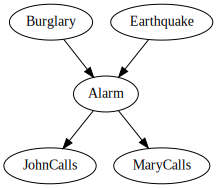

In [17]:
bn = BayesianNet('Earthquake.net')

print('The adjacent list representation is :')
print(bn.graph.graph)

bn.graph

We can use `bn.cpts.outcome_space` to get the outcome space and `bn.cpts.factors` to get all factors.

In [18]:
bn.cpts.outcome_space

OrderedDict([('Burglary', ('True', 'False')),
             ('Earthquake', ('True', 'False')),
             ('Alarm', ('True', 'False')),
             ('JohnCalls', ('True', 'False')),
             ('MaryCalls', ('True', 'False'))])

In [19]:
bn.cpts.factors

{'Burglary': {'dom': ['Burglary'],
  'table': OrderedDict([(('True',), '0.01'), (('False',), '0.99')])},
 'Earthquake': {'dom': ['Earthquake'],
  'table': OrderedDict([(('True',), '0.02'), (('False',), '0.98')])},
 'Alarm': {'dom': ['Alarm', 'Burglary', 'Earthquake'],
  'table': OrderedDict([(('True', 'True', 'True'), '0.95'),
               (('False', 'True', 'True'), '0.05'),
               (('True', 'True', 'False'), '0.94'),
               (('False', 'True', 'False'), '0.06'),
               (('True', 'False', 'True'), '0.29'),
               (('False', 'False', 'True'), '0.71'),
               (('True', 'False', 'False'), '0.001'),
               (('False', 'False', 'False'), '0.999')])},
 'JohnCalls': {'dom': ['JohnCalls', 'Alarm'],
  'table': OrderedDict([(('True', 'True'), '0.9'),
               (('False', 'True'), '0.1'),
               (('True', 'False'), '0.05'),
               (('False', 'False'), '0.95')])},
 'MaryCalls': {'dom': ['MaryCalls', 'Alarm'],
  'table': OrderedD

We can use `bn.cpts` to elegantly display all the factors.

In [20]:
bn.cpts

Burglary :
| Burglary   |   Pr |
|------------+------|
| True       | 0.01 |
| False      | 0.99 |

Earthquake :
| Earthquake   |   Pr |
|--------------+------|
| True         | 0.02 |
| False        | 0.98 |

Alarm :
| Alarm   | Burglary   | Earthquake   |    Pr |
|---------+------------+--------------+-------|
| True    | True       | True         | 0.95  |
| False   | True       | True         | 0.05  |
| True    | True       | False        | 0.94  |
| False   | True       | False        | 0.06  |
| True    | False      | True         | 0.29  |
| False   | False      | True         | 0.71  |
| True    | False      | False        | 0.001 |
| False   | False      | False        | 0.999 |

JohnCalls :
| JohnCalls   | Alarm   |   Pr |
|-------------+---------+------|
| True        | True    | 0.9  |
| False       | True    | 0.1  |
| True        | False   | 0.05 |
| False       | False   | 0.95 |

MaryCalls :
| MaryCalls   | Alarm   |   Pr |
|-------------+---------+------|
| True      

## 1.2 Save Bayesian network to a file

We can use `save_to_file(file_name)`function of BayesianNet class to save the Bayesian network as a '.net' file. This will create a 'file_name.net' file under the working directory.

In [21]:
bn.save_to_file('save')

## 1.3 Insert and remove nodes

We can use `insert_node(node, parents:list, cpt, outcome_space = None)` to insert a node.

Parameters:
- *node*: name of inserted node
- *parents*: must specify the parents of the inserted node, as a list
- *cpt*: the conditional probability table of the inserted node
- *outcome_space*: the outcome space of the inserted node

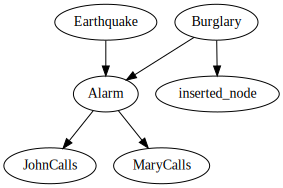

In [22]:
new_cpt = {'dom': ['H_node', 'Burglary'],
        'table': odict([(('True', 'True'), '0.2'),
                      (('False', 'True'), '0.8'),
                      (('True', 'False'), '0.75'),
                      (('False', 'False'), '0.25')])}
new_outcome_space = {'inserted_node': ('+inserted_node', '-inserted_node')}

bn.insert_node('inserted_node', ['Burglary'], new_cpt, new_outcome_space)
bn.graph

We can also use `remove_node(node, cpts=None)` to remove a node. This action usually happens on leaf nodes. If a non-leaf node need to be removed, the new distribution of all children must be given. 

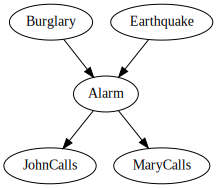

In [23]:
bn.remove_node('inserted_node', cpts=None)
bn.graph

## 1.4 Connect and disconnect nodes with edges

We can use `insert_edge(edge, cpt)` to connect an edge.
Parameters:
- *edge:* a tuple (A, B) which represents edge A -> B, and nodes on both side should be in the graph
- *cpt:* user should give a new cpt of node B

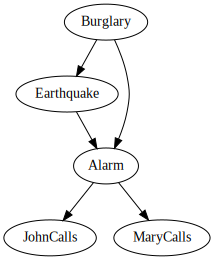

In [24]:
new_cpt_earth = {'dom': ['Earthquake', 'Burglary'],
                 'table': odict([(('True', 'True'), '0.2'),
                                 (('False', 'True'), '0.8'),
                                 (('True', 'False'), '0.75'),
                                 (('False', 'False'), '0.25')])}
bn.insert_edge(('Burglary','Earthquake'), new_cpt_earth)
bn.graph

We can use `remove_edge(edge, cpt)` to disconnect an edge.
Parameters:
- *edge:* a tuple (A, B) which represents edge A -> B, and nodes on both side should be in the graph
- *cpt:* user should give a new cpt of node B

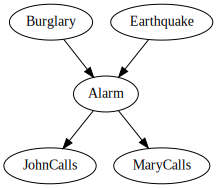

In [25]:
original_cpt_earth =   {'dom': ('Earthquake'),
                       'table': odict([
                               (('True'), '0.02'),
                               (('False'), '0.98'),])}
bn.remove_edge(('Burglary','Earthquake'), original_cpt_earth)
bn.graph

## 1.5 Specify probabilities for a node

This function has been achieved when we insert or remove a node, and connect or disconnect an edge.

# 2. Pruning and pre-processing techniques for inference

## 2.1 Edge and node pruning

We can use `pruning_net(q:set = set(), e: dict = {})` to prune a Bayesian Network, the return value is a new BayesianNet.
This function is a combination of `pruning_nodes(q:set = set(), e: set = set())` and `pruning_edges(e: dict = {})`
Parameters:
- *q:* a set of query variables
- *e:* a set of query evidence

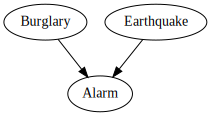

In [26]:
bn_after_pruning = bn.pruning_net({'Burglary'},{'Alarm':'True'})
bn_after_pruning.graph

## 2.2 Min-fill heuristic for variable order elimination

We have implemented three class `MinFill`, `MinDegree` and `MinFill_MinDegree` which inherit parent class `EliminationOrder`. `MinFill_MinDegree` is the Deterministic and stochastic composition of min-fill heuristic with min-degree heuristic. The class can be instantiated with an input *type:BayesianNet*. We can use `get_elimination_order()` to get an elimination order.

In [27]:
min_fill_degree = MinFill_MinDegree(bn)

min_fill_degree.get_elimination_order()

['JohnCalls', 'MaryCalls', 'Burglary', 'Earthquake', 'Alarm']

## 2.3 Depth-first search to find an optimal elimination order with lower-bound pruning
We can initialize an EliminationOrder class by `EliminationOrder(bn)`, where bn is a BayesianNet.

Then we use `find_optimal_order_by_DFS(using_degeneracy = True)` to get the elimination order.

In [28]:
e_order = EliminationOrder(bn)

e_order.find_optimal_order_by_DFS(using_degeneracy = True)

The lower bound of degeneracy is 2


('Burglary', 'Earthquake', 'Alarm', 'JohnCalls', 'MaryCalls')

---
# 3. Exact inference

## 3.1 / 3.2 Jointree representation and Elimination order to JoinTree

We usually initialize a Jointree from a Bayesian network with a elimination order using `bn.to_jointree(order: tuple)`.

In addition, we can initialize a Jointree according to user specified parameters, in that case, *the cluster_graph* should be a *cluster_graph* class and the *factors* shoud be a *Factors* class.

We can use `jointree.cluster_graph` to display the jointree.

In [29]:
order = MinFill_MinDegree(bn).get_elimination_order()

earthquake_jointree = bn.to_jointree(order)
earthquake_jointree.evidence({'MaryCalls':'True', 'Burglary':'True'})
earthquake_jointree.get_message()
earthquake_jointree.clusters_query({'Alarm'})
earthquake_jointree

('Alarm', 'JohnCalls') :
| Alarm   | JohnCalls   |   Pr |
|---------+-------------+------|
| True    | True        | 0.9  |
| True    | False       | 0.1  |
| False   | True        | 0.05 |
| False   | False       | 0.95 |

('Alarm', 'MaryCalls') :
| Alarm   | MaryCalls   |   Pr |
|---------+-------------+------|
| True    | True        | 0.7  |
| True    | False       | 0.3  |
| False   | True        | 0.01 |
| False   | False       | 0.99 |

('Alarm', 'Burglary', 'Earthquake') :
| Burglary   | Alarm   | Earthquake   |      Pr |
|------------+---------+--------------+---------|
| True       | True    | True         | 0.0095  |
| True       | True    | False        | 0.0094  |
| True       | False   | True         | 0.0005  |
| True       | False   | False        | 0.0006  |
| False      | True    | True         | 0.2871  |
| False      | True    | False        | 0.00099 |
| False      | False   | True         | 0.7029  |
| False      | False   | False        | 0.98901 |

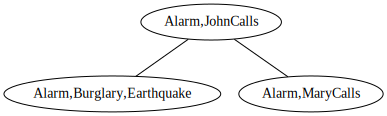

In [30]:
order = ['JohnCalls', 'MaryCalls', 'Burglary', 'Earthquake', 'Alarm']

earthquake_jointree = bn.to_jointree(order)
earthquake_jointree.cluster_graph

We can use `jointree.factors` to display the factors of the jointree.

In [31]:
earthquake_jointree.factors

('Alarm', 'JohnCalls') :
| Alarm   | JohnCalls   |   Pr |
|---------+-------------+------|
| True    | True        | 0.9  |
| True    | False       | 0.1  |
| False   | True        | 0.05 |
| False   | False       | 0.95 |

('Alarm', 'MaryCalls') :
| Alarm   | MaryCalls   |   Pr |
|---------+-------------+------|
| True    | True        | 0.7  |
| True    | False       | 0.3  |
| False   | True        | 0.01 |
| False   | False       | 0.99 |

('Alarm', 'Burglary', 'Earthquake') :
| Burglary   | Alarm   | Earthquake   |      Pr |
|------------+---------+--------------+---------|
| True       | True    | True         | 0.0095  |
| True       | True    | False        | 0.0094  |
| True       | False   | True         | 0.0005  |
| True       | False   | False        | 0.0006  |
| False      | True    | True         | 0.2871  |
| False      | True    | False        | 0.00099 |
| False      | False   | True         | 0.7029  |
| False      | False   | False        | 0.98901 |

## 3.3 A function to set evidence

We can use `jointree.evidence(evi:dict = {})` to set the evidence. This will result in the probability 1 for corresponding rows that consists with the evidence. We can use `jointree.display_evidence()` to check whether the evidence has been set.

In [32]:
earthquake_jointree.evidence({'Alarm':'True', 'Burglary':'True'})
earthquake_jointree.display_evidence()

| Alarm   |   Pr |
|---------+------|
| True    |    1 |
| False   |    0 |

| Burglary   |   Pr |
|------------+------|
| True       |    1 |
| False      |    0 |



## 3.4  A function to answer a query based on the jointree clusters

To answer a query, we can do the following steps:
- 1) use `jointree.evidence(evi:dict = {})` to set evidence
- 2) use `jointree.get_message()` to do message passing
- 3) use `jointree.cluster_query()` to ask the query

We can use `jointree.get_message()` to do message passing. By calling this function, it will automatically display all the messages.

In [33]:
earthquake_jointree.get_message()

(('Alarm', 'Burglary', 'Earthquake'), ('Alarm', 'JohnCalls')) :
| Alarm   |     Pr |
|---------+--------|
| True    | 0.0189 |
| False   | 0      |

(('Alarm', 'MaryCalls'), ('Alarm', 'JohnCalls')) :
| Alarm   |   Pr |
|---------+------|
| True    |    1 |
| False   |    0 |

(('Alarm', 'JohnCalls'), ('Alarm', 'Burglary', 'Earthquake')) :
| Alarm   |   Pr |
|---------+------|
| True    |    1 |
| False   |    0 |

(('Alarm', 'JohnCalls'), ('Alarm', 'MaryCalls')) :
| Alarm   |     Pr |
|---------+--------|
| True    | 0.0189 |
| False   | 0      |

We can use `clusters_query(var:set, query_root:Cluster = None, update_message = False, need_normalize = True)` to ask a query.

Parameters:
- *var:* a set of variables
- *query_root:* root of the query, type: Cluster, if not provided: generated automatically
- *update_message:* whether to update the message, default: False
- *need_normalize:* whether to normalize the result, default: True

In [34]:
earthquake_jointree.clusters_query({'MaryCalls'})

{'dom': ('MaryCalls',),
 'table': OrderedDict([(('True',), '0.7'), (('False',), '0.3')])}

User can clear the history information to start a new query by `jointree.query_clear()`

In [35]:
earthquake_jointree.query_clear()

# 3.5 Four functions of Jointree transformations

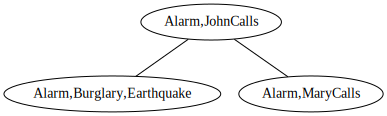

In [36]:
earthquake_jointree.cluster_graph

We can use `jointree.add_a_variable(var, cluster_node:Cluster)` to add a variable.

Parameters:
- *var:* a tuple of variables
- *cluster_node:* which cluster to add

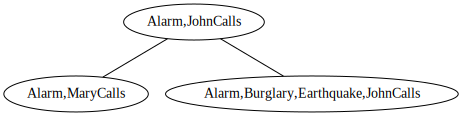

In [37]:
earthquake_jointree.add_a_variable(('JohnCalls',),Cluster(('Alarm','Burglary','Earthquake')))

earthquake_jointree.cluster_graph

We can use `jointree.merge_clusters(cluster_n1, cluster_n2)` to merge two clusters

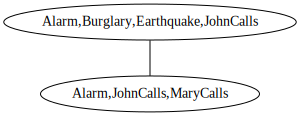

In [38]:
earthquake_jointree.merge_clusters(Cluster(('Alarm','JohnCalls')),Cluster(('Alarm','MaryCalls')))
earthquake_jointree.cluster_graph

We can use `jointree.factors` to check the resulting factors after merging.

In [39]:
earthquake_jointree.factors

('Alarm', 'Burglary', 'Earthquake', 'JohnCalls') :
| Burglary   | Alarm   | Earthquake   |      Pr |
|------------+---------+--------------+---------|
| True       | True    | True         | 0.0095  |
| True       | True    | False        | 0.0094  |
| True       | False   | True         | 0.0005  |
| True       | False   | False        | 0.0006  |
| False      | True    | True         | 0.2871  |
| False      | True    | False        | 0.00099 |
| False      | False   | True         | 0.7029  |
| False      | False   | False        | 0.98901 |

('Alarm', 'JohnCalls', 'MaryCalls') :
| Alarm   | JohnCalls   | MaryCalls   |     Pr |
|---------+-------------+-------------+--------|
| True    | True        | True        | 0.63   |
| True    | True        | False       | 0.27   |
| True    | False       | True        | 0.07   |
| True    | False       | False       | 0.03   |
| False   | True        | True        | 0.0005 |
| False   | True        | False       | 0.0495 |
| False   | False 

We can use `jointree.add_a_cluster(cluster_node:Cluster, old_cluster_node:Cluster)` to add a cluster.

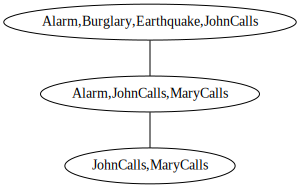

In [40]:
earthquake_jointree.add_a_cluster(Cluster(('JohnCalls','MaryCalls')),Cluster(('Alarm','JohnCalls','MaryCalls')))
earthquake_jointree.cluster_graph

We can use `jointree.remove_a_cluster(scluster_node:Cluster)` to remove a cluster.

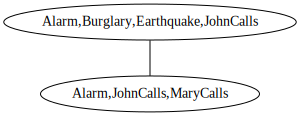

In [41]:
earthquake_jointree.remove_a_cluster(Cluster(('JohnCalls','MaryCalls')))
earthquake_jointree.cluster_graph

# 4 Gibbs sampling

**Four required functions are integrated into GibbsSampling class, we categorize as:**

- 4.1 A function that let the user specify the number of chains.
- 4.2 A function to mix up chains until convergence.
- 4.3 A function that samples the chains for a specified number of samples.
- 4.4 A function to answer queries based on the samples.

We can initialize a **GibbsSampling** class from a Bayesian network using `GibbsSampling(net)`.
Parameters:
- *net:* a Bayesian network

In [42]:
bn = BayesianNet('earthquake.net')
gibbs = GibbsSampling(bn)

We can use `gibb.factors` to display the factors after set the evidence.

In [43]:
gibbs.factors

Burglary :
| Burglary   |   Pr |
|------------+------|
| True       | 0.01 |
| False      | 0.99 |

Earthquake :
| Earthquake   |   Pr |
|--------------+------|
| True         | 0.02 |
| False        | 0.98 |

Alarm :
| Alarm   | Burglary   | Earthquake   |    Pr |
|---------+------------+--------------+-------|
| True    | True       | True         | 0.95  |
| False   | True       | True         | 0.05  |
| True    | True       | False        | 0.94  |
| False   | True       | False        | 0.06  |
| True    | False      | True         | 0.29  |
| False   | False      | True         | 0.71  |
| True    | False      | False        | 0.001 |
| False   | False      | False        | 0.999 |

JohnCalls :
| JohnCalls   | Alarm   |   Pr |
|-------------+---------+------|
| True        | True    | 0.9  |
| False       | True    | 0.1  |
| True        | False   | 0.05 |
| False       | False   | 0.95 |

MaryCalls :
| MaryCalls   | Alarm   |   Pr |
|-------------+---------+------|
| True      

We can use `gibbs.run_gibbs_sampling(self, num_samples:int = None ,num_chains:int = 4,  init_approach = 'Uniform', step = 1000, burn_in:int = 0, seed = None, convergence_threshold = 1.1)->pd.DataFrame:` to start gibbs sampling. The return value is a pandas data frame.

If gibbs.run_gibbs_sampling prompts an error, we need change the init_approach as `init_approach='ForwardSampling'` and redo this command.

Parameters:
- *num_samples:* number of samples, if None then converge automatically **--(questions 4.2 4.3)**
- *num_chains:* number of chains **--(questions 4.1)**
- *init_approach:* two methods: Uniform or forward sampling
- *step:* steps, default: 1000
- *burn_in:* number of burn-in samples
- *seed:* random seed
- *convergence_threshold:* Gibbs sampling converge when $\hat{R}$ < convergence_threshold **--(questions 4.2)**

In [44]:
data_frame = gibbs.run_gibbs_sampling(burn_in = 1000)

finish 1.0 steps
The gibbs sampling has already convergence
Gibbs sampling finished.


After running Gibbs sampling, we can query on it using `query(var:set, e:dict = {})`.

**(question 4.4)**

In [45]:
gibbs.query({'MaryCalls'}, {'Alarm':'True', 'Burglary':'True'})

{'dom': ('MaryCalls',),
 'table': OrderedDict([(('True',), '0.6111111111111112'),
              (('False',), '0.3888888888888889')])}

## Comparison of exact inference and approximate inference

In [46]:
order = ['JohnCalls', 'MaryCalls', 'Burglary', 'Earthquake', 'Alarm']
earthquake_jointree = bn.to_jointree(order)
earthquake_jointree.evidence({'Alarm':'True', 'Burglary':'True'})
earthquake_jointree.get_message()
earthquake_jointree.clusters_query({'MaryCalls'})

{'dom': ('MaryCalls',),
 'table': OrderedDict([(('True',), '0.7000000000000001'),
              (('False',), '0.30000000000000004')])}

We use KL divergence to compare the result. It is shown that the result of approximate inference is very similar to the exact inference.

In [47]:
import math
from collections import OrderedDict
def kl(d1, d2):
    result = 0
    for i in d1:
        result += float(d1[i]) * math.log(float(d1[i])/float(d2[i]))
    return result

d1 = OrderedDict([(('True',), '0.7097902097902098'),
              (('False',), '0.2902097902097902')])

d2 = OrderedDict([(('True',), '0.7000000000000001'),
              (('False',), '0.30000000000000004')])

kl(d1, d2)

0.00022965970887398567


## This is the end of the code demostration. 

To show different size of Bayesian network, below is another two test results on a medium network 'child.net' and a large network 'hailfinder.net'
# <span style = "color:black">----------------------------------------------------------------------------------------</span>

---
## Test result on a Medium Bayesian network 
### child.net

In [48]:
bn_medium_child = BayesianNet('child.net')

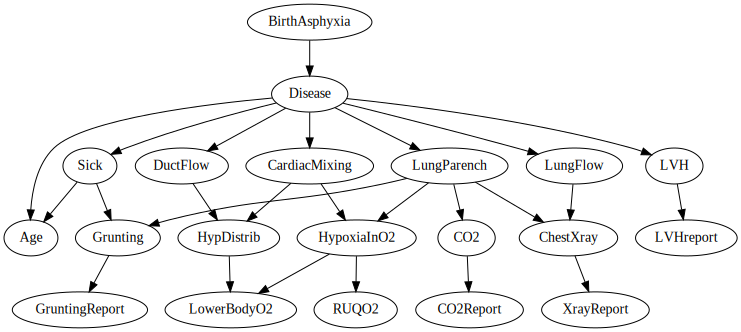

In [49]:
bn_medium_child.graph

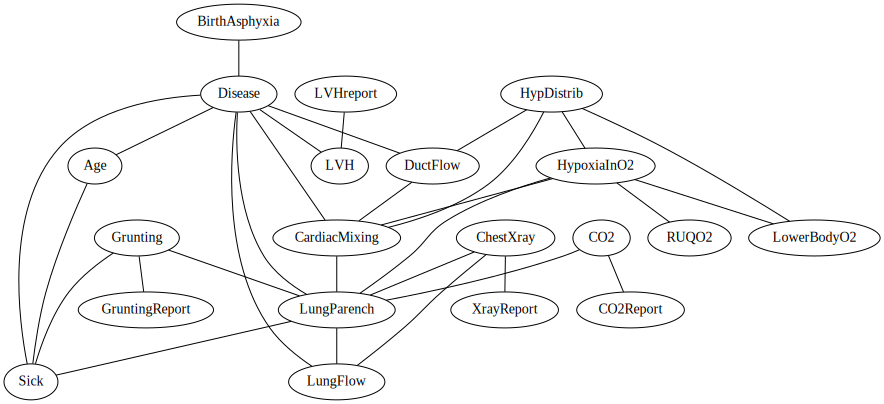

In [50]:
bn_medium_child.moralize()

In [51]:
bn_medium_child.cpts

BirthAsphyxia :
| BirthAsphyxia   |   Pr |
|-----------------+------|
| yes             |  0.1 |
| no              |  0.9 |

HypDistrib :
| HypDistrib   | DuctFlow   | CardiacMixing   |   Pr |
|--------------+------------+-----------------+------|
| Equal        | Lt_to_Rt   | None            | 0.95 |
| Unequal      | Lt_to_Rt   | None            | 0.05 |
| Equal        | Lt_to_Rt   | Mild            | 0.95 |
| Unequal      | Lt_to_Rt   | Mild            | 0.05 |
| Equal        | Lt_to_Rt   | Complete        | 0.95 |
| Unequal      | Lt_to_Rt   | Complete        | 0.05 |
| Equal        | Lt_to_Rt   | Transp.         | 0.95 |
| Unequal      | Lt_to_Rt   | Transp.         | 0.05 |
| Equal        | None       | None            | 0.95 |
| Unequal      | None       | None            | 0.05 |
| Equal        | None       | Mild            | 0.95 |
| Unequal      | None       | Mild            | 0.05 |
| Equal        | None       | Complete        | 0.95 |
| Unequal      | None       | Complet

### task 1.1 Insert and remove nodes

#### insert a node "H_node" to the graph with cpt

In [52]:
cpt_H = {'dom': ['H_node', 'Sick'],
        'table': odict([(('True', 'yes'), '0.2'),
               (('False', 'yes'), '0.8'),
               (('True', 'no'), '0.75'),
               (('False', 'no'), '0.25')])}

In [53]:
bn_medium_child.insert_node('H_node',['Sick'],cpt_H,('True','False'))

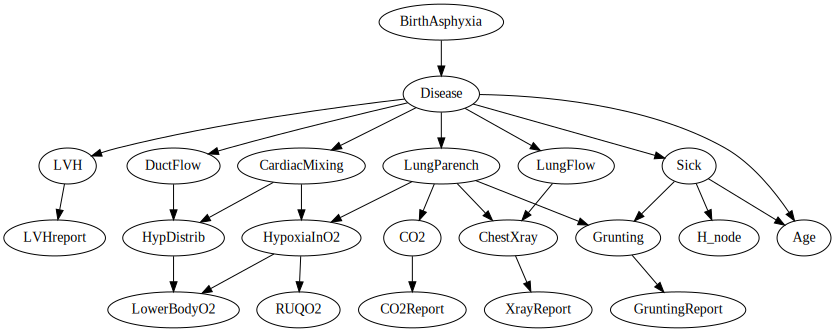

In [54]:
bn_medium_child.graph

In [55]:
bn_medium_child.cpts.print_factor('H_node')

| H_node   | Sick   |   Pr |
|----------+--------+------|
| True     | yes    | 0.2  |
| False    | yes    | 0.8  |
| True     | no     | 0.75 |
| False    | no     | 0.25 |



#### Delete "H_node" node from the graph

In [56]:
bn_medium_child.remove_node('H_node',cpt_H)

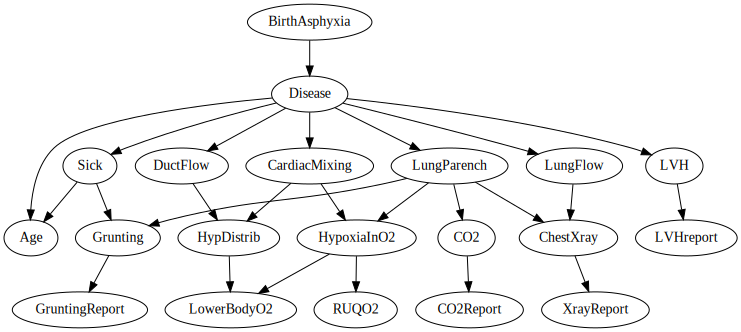

In [57]:
bn_medium_child.graph

### task 1.2 Connect and disconnect nodes with edges

In [58]:
cpt_2 = {'dom': ['GruntingReport', 'Sick'],
        'table': odict([(('yes', 'yes'), '0.2'),
               (('no', 'yes'), '0.8'),
               (('yes', 'no'), '0.75'),
               (('no', 'no'), '0.25')])}

In [59]:
bn_medium_child.insert_edge(('Sick', 'GruntingReport'), cpt_2)

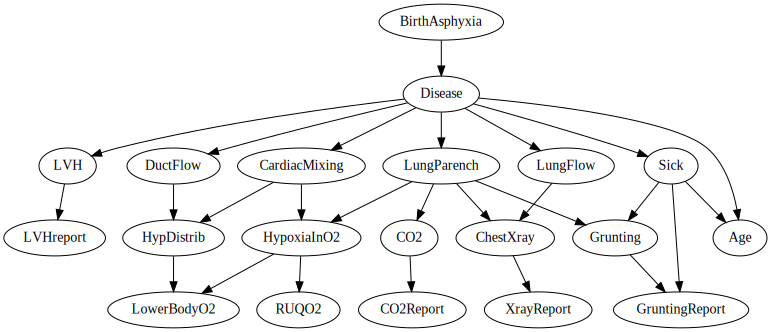

In [60]:
bn_medium_child.graph

In [61]:
bn_medium_child.remove_edge(('Sick', 'GruntingReport'), cpt_2)

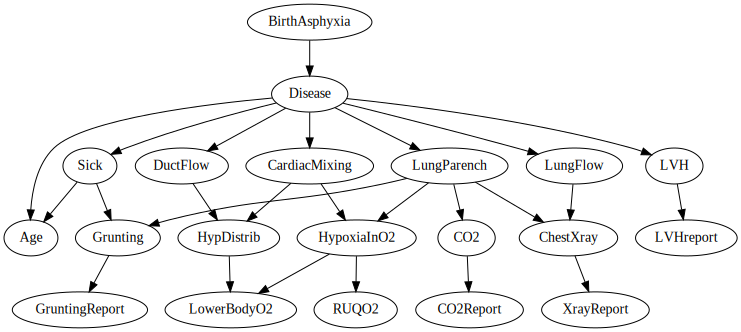

In [62]:
bn_medium_child.graph

### task 1.3 specify probabilities for a node

In [63]:
bn_medium_child.cpts.print_factor('Sick')

| Sick   | Disease   |   Pr |
|--------+-----------+------|
| yes    | PFC       |  0.4 |
| no     | PFC       |  0.6 |
| yes    | TGA       |  0.3 |
| no     | TGA       |  0.7 |
| yes    | Fallot    |  0.2 |
| no     | Fallot    |  0.8 |
| yes    | PAIVS     |  0.3 |
| no     | PAIVS     |  0.7 |
| yes    | TAPVD     |  0.7 |
| no     | TAPVD     |  0.3 |
| yes    | Lung      |  0.7 |
| no     | Lung      |  0.3 |



### task 1.4 Save Bayesian network to a file

In [64]:
bn_medium_child.save_to_file('child_copy')

### task 1.5 Load Baysian network from a file

In [65]:
Path_child_copy = "child_copy.net"
bn_m1_copy = BayesianNet(Path_child_copy)

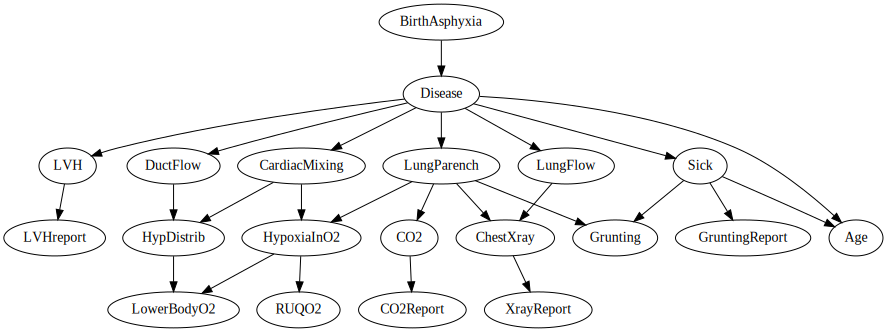

In [66]:
bn_m1_copy.graph

### Task2.1 Network pruning techniques based on query struture. These techniques are composed of edge and node pruning

In [67]:
bn_med_pruning = bn_medium_child.pruning_net({'RUQO2'},{'Sick':'yes','CO2':'LOW'})

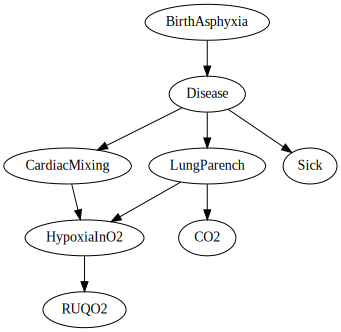

In [68]:
bn_med_pruning.graph

In [69]:
bn_med_pruning.cpts.print_all_factor

<bound method FactorsBase.print_all_factor of BirthAsphyxia :
| BirthAsphyxia   |   Pr |
|-----------------+------|
| yes             |  0.1 |
| no              |  0.9 |

HypoxiaInO2 :
| HypoxiaInO2   | CardiacMixing   | LungParench   |   Pr |
|---------------+-----------------+---------------+------|
| Mild          | None            | Normal        | 0.93 |
| Moderate      | None            | Normal        | 0.05 |
| Severe        | None            | Normal        | 0.02 |
| Mild          | None            | Congested     | 0.15 |
| Moderate      | None            | Congested     | 0.8  |
| Severe        | None            | Congested     | 0.05 |
| Mild          | None            | Abnormal      | 0.7  |
| Moderate      | None            | Abnormal      | 0.2  |
| Severe        | None            | Abnormal      | 0.1  |
| Mild          | Mild            | Normal        | 0.1  |
| Moderate      | Mild            | Normal        | 0.8  |
| Severe        | Mild            | Normal      

### Task2.2 Min-fill heuristic for variable order elimination. Deterministic and stochastic composition of min-fill heuristic with min-degree heuristic

#### MinDegree

In [70]:
min_degree = MinDegree(bn_medium_child)
min_degree.get_elimination_order()

['BirthAsphyxia',
 'LVHreport',
 'RUQO2',
 'CO2Report',
 'CO2',
 'XrayReport',
 'GruntingReport',
 'LVH',
 'ChestXray',
 'Grunting',
 'LowerBodyO2',
 'Age',
 'LungFlow',
 'Sick',
 'HypDistrib',
 'HypoxiaInO2',
 'Disease',
 'DuctFlow',
 'CardiacMixing',
 'LungParench']

#### MinFill

In [71]:
min_fill = MinFill(bn_medium_child)
min_fill.get_elimination_order()

['BirthAsphyxia',
 'HypDistrib',
 'HypoxiaInO2',
 'CO2',
 'ChestXray',
 'Grunting',
 'LVHreport',
 'LowerBodyO2',
 'RUQO2',
 'CO2Report',
 'XrayReport',
 'Disease',
 'GruntingReport',
 'Age',
 'LVH',
 'DuctFlow',
 'CardiacMixing',
 'LungParench',
 'LungFlow',
 'Sick']

#### Min_degree Min_Fill

In [72]:
min_degree_min_fill = MinFill_MinDegree(bn_medium_child)
min_degree_min_fill.get_elimination_order()

['BirthAsphyxia',
 'LVHreport',
 'RUQO2',
 'CO2Report',
 'CO2',
 'XrayReport',
 'GruntingReport',
 'LVH',
 'ChestXray',
 'Grunting',
 'LowerBodyO2',
 'Age',
 'LungFlow',
 'Sick',
 'HypDistrib',
 'HypoxiaInO2',
 'Disease',
 'DuctFlow',
 'CardiacMixing',
 'LungParench']

## task 3.1 jointree be speciﬁed by the user

In [73]:
child_jointree = bn_medium_child.to_jointree(['BirthAsphyxia','HypDistrib',
                                              'HypoxiaInO2','CO2',
                                              'ChestXray','Grunting',
                                              'LVHreport','LowerBodyO2',
                                              'RUQO2','CO2Report',
                                              'XrayReport','Disease',
                                              'GruntingReport','Age',
                                              'LVH','DuctFlow',
                                              'CardiacMixing','LungParench',
                                              'LungFlow','Sick'])

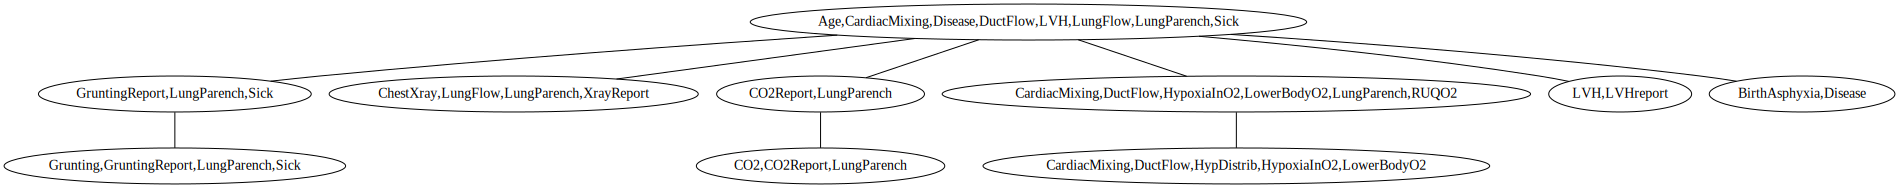

In [74]:
child_jointree.cluster_graph

## task 3.2 jointree given order

In [75]:
min_degree_min_fill = MinFill_MinDegree(bn_medium_child)
order = min_degree_min_fill.get_elimination_order()

In [76]:
child_jointree = bn_medium_child.to_jointree(order)

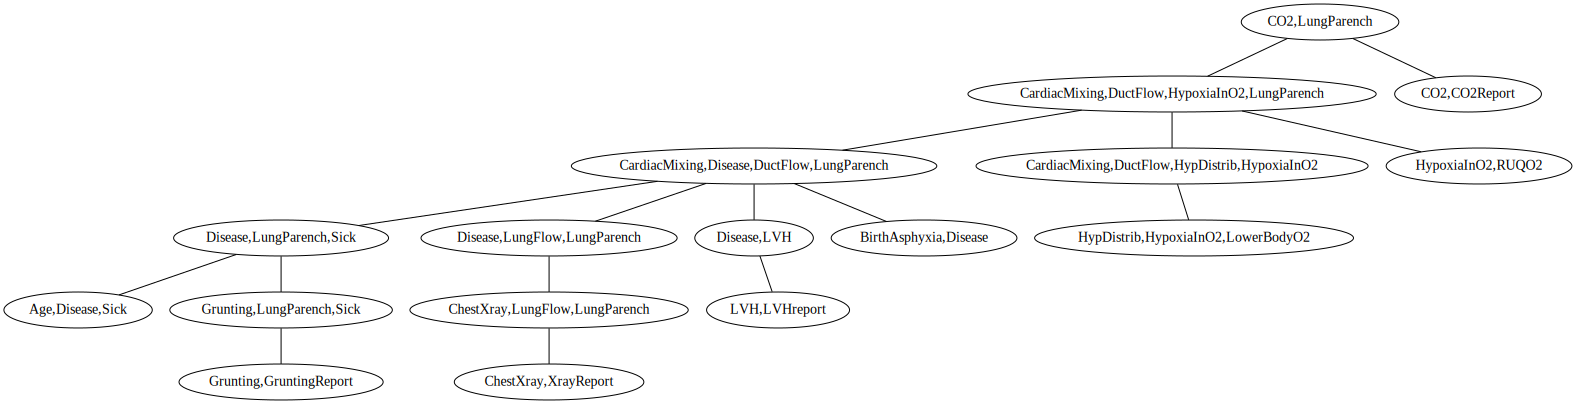

In [77]:
child_jointree.cluster_graph

In [78]:
%%time
child_jointree.factors

Wall time: 0 ns


('BirthAsphyxia', 'Disease') :
| BirthAsphyxia   | Disease   |        Pr |
|-----------------+-----------+-----------|
| yes             | PFC       | 0.02      |
| yes             | TGA       | 0.03      |
| yes             | Fallot    | 0.025     |
| yes             | PAIVS     | 0.015     |
| yes             | TAPVD     | 0.005     |
| yes             | Lung      | 0.005     |
| no              | PFC       | 0.027551  |
| no              | TGA       | 0.303061  |
| no              | Fallot    | 0.266327  |
| no              | PAIVS     | 0.211224  |
| no              | TAPVD     | 0.0459184 |
| no              | Lung      | 0.0459184 |

('LVH', 'LVHreport') :
| LVH   | LVHreport   |   Pr |
|-------+-------------+------|
| yes   | yes         | 0.9  |
| yes   | no          | 0.1  |
| no    | yes         | 0.05 |
| no    | no          | 0.95 |

('HypoxiaInO2', 'RUQO2') :
| HypoxiaInO2   | RUQO2   |   Pr |
|---------------+---------+------|
| Mild          | <5      |  0.1 |
| Mild    

# task 3.3 A function to set evidence

In [79]:
child_jointree.evidence({'LVH':'yes','CO2':'Normal','XrayReport':'Oligaemic'})

{'LVH': {'dom': ('LVH',), 'table': OrderedDict([(('yes',), 1), (('no',), 0)])},
 'CO2': {'dom': ('CO2',),
  'table': OrderedDict([(('Normal',), 1), (('Low',), 0), (('High',), 0)])},
 'XrayReport': {'dom': ('XrayReport',),
  'table': OrderedDict([(('Normal',), 0),
               (('Oligaemic',), 1),
               (('Plethoric',), 0),
               (('Grd_Glass',), 0),
               (('Asy/Patchy',), 0)])}}

# task 3.4  A function to answer a query based on the jointree clusters

In [80]:
child_jointree.get_message()

(('Age', 'Disease', 'Sick'), ('Disease', 'LungParench', 'Sick')) :
| Sick   | Disease   |   Pr |
|--------+-----------+------|
| yes    | PFC       |  0.4 |
| yes    | TGA       |  0.3 |
| yes    | Fallot    |  0.2 |
| yes    | PAIVS     |  0.3 |
| yes    | TAPVD     |  0.7 |
| yes    | Lung      |  0.7 |
| no     | PFC       |  0.6 |
| no     | TGA       |  0.7 |
| no     | Fallot    |  0.8 |
| no     | PAIVS     |  0.7 |
| no     | TAPVD     |  0.3 |
| no     | Lung      |  0.3 |

(('Grunting', 'GruntingReport'), ('Grunting', 'LungParench', 'Sick')) :
| Pr   |
|------|

(('Grunting', 'LungParench', 'Sick'), ('Disease', 'LungParench', 'Sick')) :
| Sick   | LungParench   |   Pr |
|--------+---------------+------|
| yes    | Normal        |    1 |
| yes    | Congested     |    1 |
| yes    | Abnormal      |    1 |
| no     | Normal        |    1 |
| no     | Congested     |    1 |
| no     | Abnormal      |    1 |

(('Disease', 'LungParench', 'Sick'), ('CardiacMixing', 'Disease', 'DuctF

In [81]:
child_jointree.clusters_query({'DuctFlow'})

{'dom': ('DuctFlow',),
 'table': OrderedDict([(('Lt_to_Rt',), '0.941597194438559'),
              (('None',), '0.04424370341273269'),
              (('Rt_to_Lt',), '0.014159102148708308')])}

# task 3.5 four jointree functions

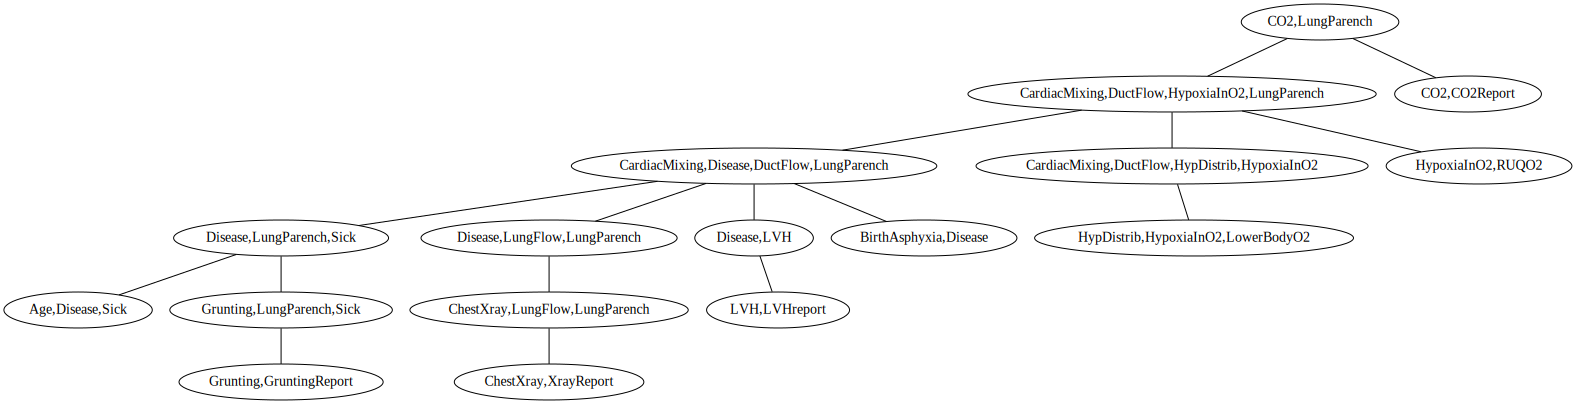

In [82]:
child_jointree.cluster_graph

## Add a variable to a cluster

In [83]:
child_jointree.add_a_variable(('LungParench',),Cluster(('Age','Disease','Sick')))

In [84]:
child_jointree.factors[Cluster(('Age','Disease','LungParench','Sick'))]

{'dom': ('Age', 'Sick', 'Disease'),
 'table': OrderedDict([(('0-3_days', 'yes', 'PFC'), 0.38),
              (('0-3_days', 'yes', 'TGA'), 0.24),
              (('0-3_days', 'yes', 'Fallot'), 0.13999999999999999),
              (('0-3_days', 'yes', 'PAIVS'), 0.24),
              (('0-3_days', 'yes', 'TAPVD'), 0.5599999999999999),
              (('0-3_days', 'yes', 'Lung'), 0.63),
              (('0-3_days', 'no', 'PFC'), 0.51),
              (('0-3_days', 'no', 'TGA'), 0.48999999999999994),
              (('0-3_days', 'no', 'Fallot'), 0.2),
              (('0-3_days', 'no', 'PAIVS'), 0.5599999999999999),
              (('0-3_days', 'no', 'TAPVD'), 0.21),
              (('0-3_days', 'no', 'Lung'), 0.24),
              (('4-10_days', 'yes', 'PFC'), 0.012),
              (('4-10_days', 'yes', 'TGA'), 0.045),
              (('4-10_days', 'yes', 'Fallot'), 0.03),
              (('4-10_days', 'yes', 'PAIVS'), 0.045),
              (('4-10_days', 'yes', 'TAPVD'), 0.105),
              (('4-10_

## Merge Clusters

In [85]:
child_jointree.merge_clusters(Cluster(('Disease','LungParench','Sick')),Cluster(('Grunting','LungParench','Sick')))

In [86]:
child_jointree.factors[Cluster(('Disease','Grunting','LungParench','Sick'))]

{'dom': ('Grunting', 'Sick', 'LungParench'),
 'table': OrderedDict([(('yes', 'yes', 'Normal'), 0.2),
              (('yes', 'yes', 'Congested'), 0.4),
              (('yes', 'yes', 'Abnormal'), 0.8),
              (('yes', 'no', 'Normal'), 0.05),
              (('yes', 'no', 'Congested'), 0.2),
              (('yes', 'no', 'Abnormal'), 0.6),
              (('no', 'yes', 'Normal'), 0.8),
              (('no', 'yes', 'Congested'), 0.6),
              (('no', 'yes', 'Abnormal'), 0.2),
              (('no', 'no', 'Normal'), 0.95),
              (('no', 'no', 'Congested'), 0.8),
              (('no', 'no', 'Abnormal'), 0.4)])}

## Add Cluster

In [87]:
child_jointree.add_a_cluster(Cluster(('Grunting',)),Cluster(('Grunting','GruntingReport')))

In [88]:
child_jointree.factors[Cluster(('Grunting',))]

{'dom': (), 'table': OrderedDict()}

## Remove Cluster

In [89]:
child_jointree.remove_a_cluster(Cluster(('Grunting',)))

# task 4 Gibbs sampling

In [90]:
gibbs = GibbsSampling(bn_medium_child)

In [91]:
gibbs.factors.get_factors()

{'BirthAsphyxia': {'dom': ['BirthAsphyxia'],
  'table': OrderedDict([(('yes',), '0.1'), (('no',), '0.9')])},
 'HypDistrib': {'dom': ['HypDistrib', 'DuctFlow', 'CardiacMixing'],
  'table': OrderedDict([(('Equal', 'Lt_to_Rt', 'None'), '0.95'),
               (('Unequal', 'Lt_to_Rt', 'None'), '0.05'),
               (('Equal', 'Lt_to_Rt', 'Mild'), '0.95'),
               (('Unequal', 'Lt_to_Rt', 'Mild'), '0.05'),
               (('Equal', 'Lt_to_Rt', 'Complete'), '0.95'),
               (('Unequal', 'Lt_to_Rt', 'Complete'), '0.05'),
               (('Equal', 'Lt_to_Rt', 'Transp.'), '0.95'),
               (('Unequal', 'Lt_to_Rt', 'Transp.'), '0.05'),
               (('Equal', 'None', 'None'), '0.95'),
               (('Unequal', 'None', 'None'), '0.05'),
               (('Equal', 'None', 'Mild'), '0.95'),
               (('Unequal', 'None', 'Mild'), '0.05'),
               (('Equal', 'None', 'Complete'), '0.95'),
               (('Unequal', 'None', 'Complete'), '0.05'),
               (('

In [92]:
%%time
gibbs.run_gibbs_sampling(burn_in = 1000)

finish 1.0 steps
The gibbs sampling has already convergence
Gibbs sampling finished.
Wall time: 1min 55s


,BirthAsphyxia,HypDistrib,HypoxiaInO2,CO2,ChestXray,Grunting,LVHreport,LowerBodyO2,RUQO2,CO2Report,XrayReport,Disease,GruntingReport,Age,LVH,DuctFlow,CardiacMixing,LungParench,LungFlow,Sick
0,no,Unequal,Severe,Normal,Plethoric,yes,no,<5,<5,<7.5,Oligaemic,PFC,no,0-3_days,no,Rt_to_Lt,Complete,Abnormal,Low,no
1,no,Equal,Moderate,Normal,Plethoric,no,no,5-12,5-12,<7.5,Plethoric,TGA,no,0-3_days,no,None,Mild,Normal,High,no
2,no,Equal,Severe,Normal,Plethoric,no,yes,<5,12+,<7.5,Plethoric,TGA,no,0-3_days,no,None,Transp.,Normal,High,yes
3,no,Unequal,Severe,Normal,Plethoric,no,no,5-12,5-12,<7.5,Plethoric,TGA,no,0-3_days,yes,None,Transp.,Normal,High,no
4,no,Equal,Mild,Normal,Plethoric,no,yes,5-12,<5,<7.5,Plethoric,TGA,yes,0-3_days,yes,None,Transp.,Normal,High,no
5,no,Equal,Severe,Normal,Plethoric,no,yes,12+,5-12,<7.5,Plethoric,TGA,yes,4-10_days,no,None,Transp.,Congested,High,no
6,no,Equal,Severe,Normal,Plethoric,no,no,<5,<5,<7.5,Plethoric,TGA,no,0-3_days,no,None,Transp.,Normal,High,no
7,no,Equal,Severe,Normal,Plethoric,no,no,5-12,5-12,>=7.5,Plethoric,TGA,no,0-3_days,no,Rt_to_Lt,Transp.,Normal,High,no
8,no,Unequal,Moderate,Normal,Plethoric,no,no,12+,12+,<7.5,Plethoric,TGA,yes,0-3_days,no,None,Mild,Normal,High,no
9,no,Equal,Mild,Normal,Plethoric,no,no,5-12,12+,<7.5,Plethoric,TGA,no,0-3_days,no,None,None,Normal,High,no


In [93]:
gibbs.query({'DuctFlow'}, {'LVH':'yes','CO2':'Normal','XrayReport':'Oligaemic'}, )

{'dom': ('DuctFlow',),
 'table': OrderedDict([(('Lt_to_Rt',), '0.9643835616438357'),
              (('None',), '0.03287671232876712'),
              (('Rt_to_Lt',), '0.0027397260273972603')])}

---
## Test result on a Large Bayesian network 
### hailfinder.net

In [94]:
bn_large_hailfinder = BayesianNet('hailfinder.net')

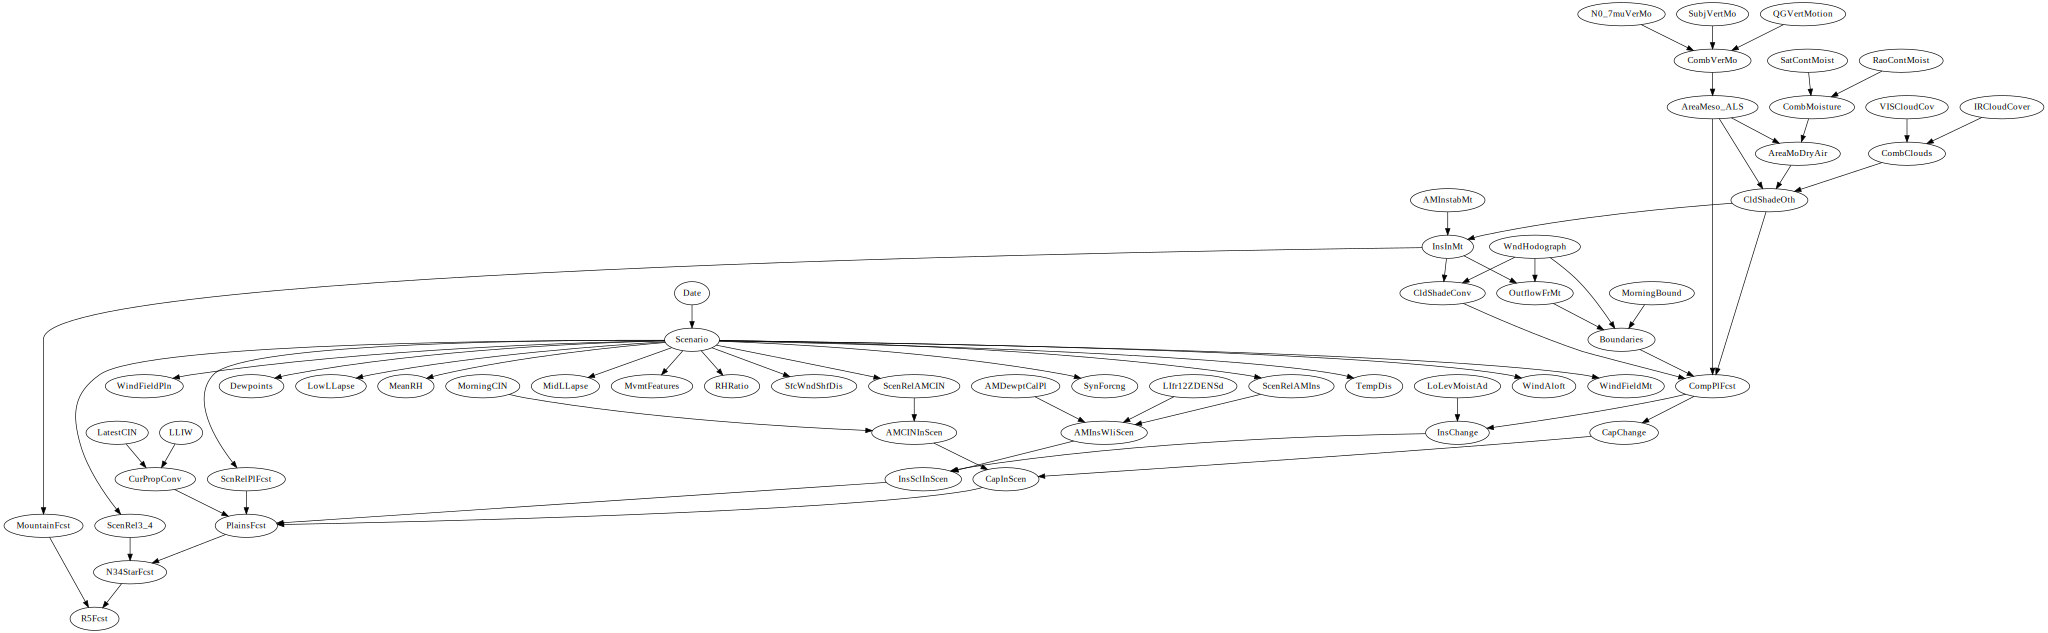

In [95]:
bn_large_hailfinder.graph

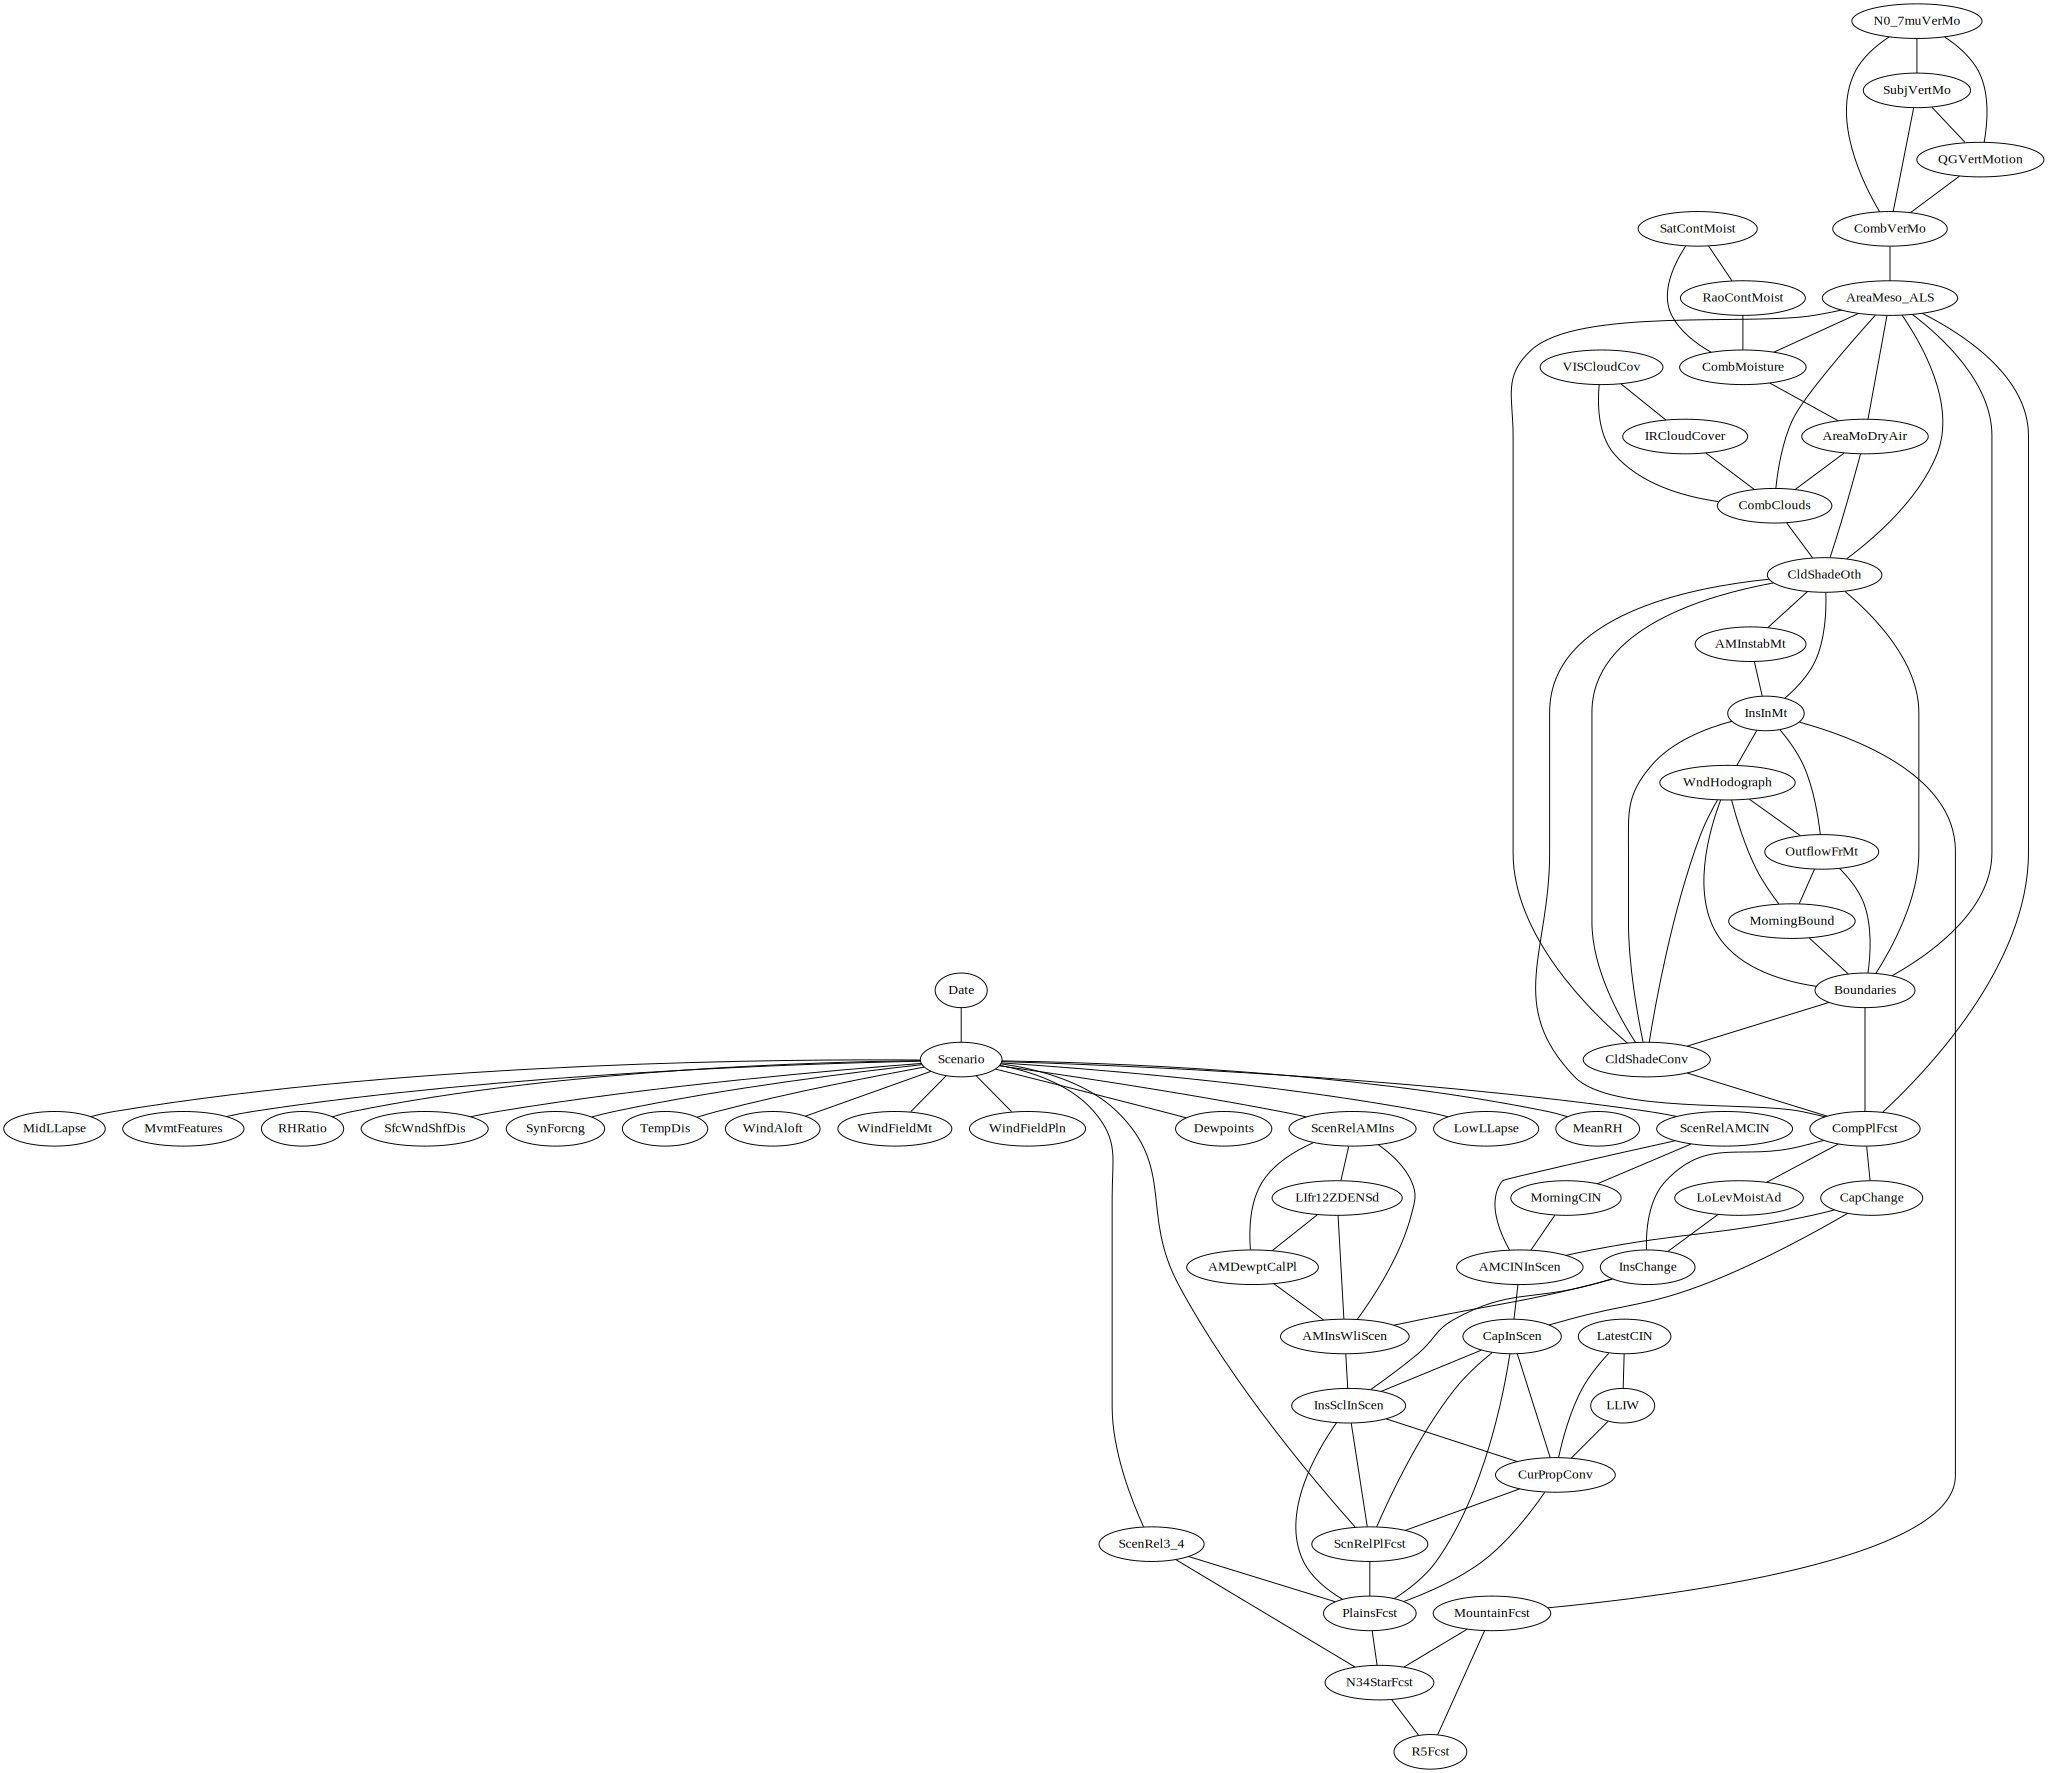

In [96]:
bn_large_hailfinder.moralize()

In [97]:
bn_large_hailfinder.cpts.factors

{'N0_7muVerMo': {'dom': ['N0_7muVerMo'],
  'table': OrderedDict([(('StrongUp',), '0.25'),
               (('WeakUp',), '0.25'),
               (('Neutral',), '0.25'),
               (('Down',), '0.25')])},
 'SubjVertMo': {'dom': ['SubjVertMo'],
  'table': OrderedDict([(('StronUp',), '0.15'),
               (('WeakUp',), '0.15'),
               (('Neutral',), '0.50'),
               (('Down',), '0.20')])},
 'QGVertMotion': {'dom': ['QGVertMotion'],
  'table': OrderedDict([(('StrongUp',), '0.15'),
               (('WeakUp',), '0.15'),
               (('Neutral',), '0.50'),
               (('Down',), '0.20')])},
 'CombVerMo': {'dom': ['CombVerMo',
   'N0_7muVerMo',
   'SubjVertMo',
   'QGVertMotion'],
  'table': OrderedDict([(('StrongUp', 'StrongUp', 'StronUp', 'StrongUp'),
                '1.0'),
               (('WeakUp', 'StrongUp', 'StronUp', 'StrongUp'), '0.0'),
               (('Neutral', 'StrongUp', 'StronUp', 'StrongUp'), '0.0'),
               (('Down', 'StrongUp', 'StronUp', 'St

### task 1.1 Insert and remove nodes

#### insert a node "H_node" to the graph with cpt

In [98]:
cpt_H = {'dom': ['H_node', 'Date'],
        'table': odict([(('True', 'May15_Jun14'), '0.2'),
               (('True', 'Jun15_Jul1'), '0.8'),
               (('True', 'Jul2_Jul15'), '0.8'),
               (('True', 'Jul16_Aug10'), '0.75'),
               (('True', 'Aug11_Aug20'), '0.25'),
               (('True', 'Aug20_Sep15'), '0.25')])}

In [99]:
bn_large_hailfinder.insert_node('H_node',['Date'],cpt_H,('True',))

In [100]:
bn_large_hailfinder.cpts.print_factor('H_node')

| H_node   | Date        |   Pr |
|----------+-------------+------|
| True     | May15_Jun14 | 0.2  |
| True     | Jun15_Jul1  | 0.8  |
| True     | Jul2_Jul15  | 0.8  |
| True     | Jul16_Aug10 | 0.75 |
| True     | Aug11_Aug20 | 0.25 |
| True     | Aug20_Sep15 | 0.25 |



#### Delete "H_node" node from the graph

In [101]:
bn_large_hailfinder.remove_node('H_node',cpt_H)

In [102]:
#try this code:
#bn_large_hailfinder.cpts.print_factor('H_node')
#then it will report error for node 'H_node has been deleted'

### task 1.2 Connect and disconnect nodes with edges

In [103]:
cpt_3 = {'dom':['N0_7muVerMo','SubjVertMo'],
         'table': odict([(('StrongUp','StronUp'),'0.2'),
                         (('StrongUp','WeakUp'),'0.2'),
                         (('StrongUp','Neutral'),'0.2'),
                         (('StrongUp','Down'),'0.7'),
                         (('WeakUp','StronUp'),'0.7'),
                         (('WeakUp','WeakUp'),'0.7'),
                         (('WeakUp','Neutral'),'0.10'),
                         (('WeakUp','Down'),'0.10'),
                         (('Neutral','StronUp'),'0.45'),
                         (('Neutral','WeakUp'),'0.35'),
                         (('Neutral','Neutral'),'0.35'),
                         (('Neutral','Down'),'0.35'),
                         (('Down','StronUp'),'0.35'),
                         (('Down','WeakUp'),'0.35'),
                         (('Down','Neutral'),'0.35'),
                         (('Down','Down'),'0.45')])}

In [104]:
bn_large_hailfinder.insert_edge(('SubjVertMo', 'N0_7muVerMo'), cpt_3)

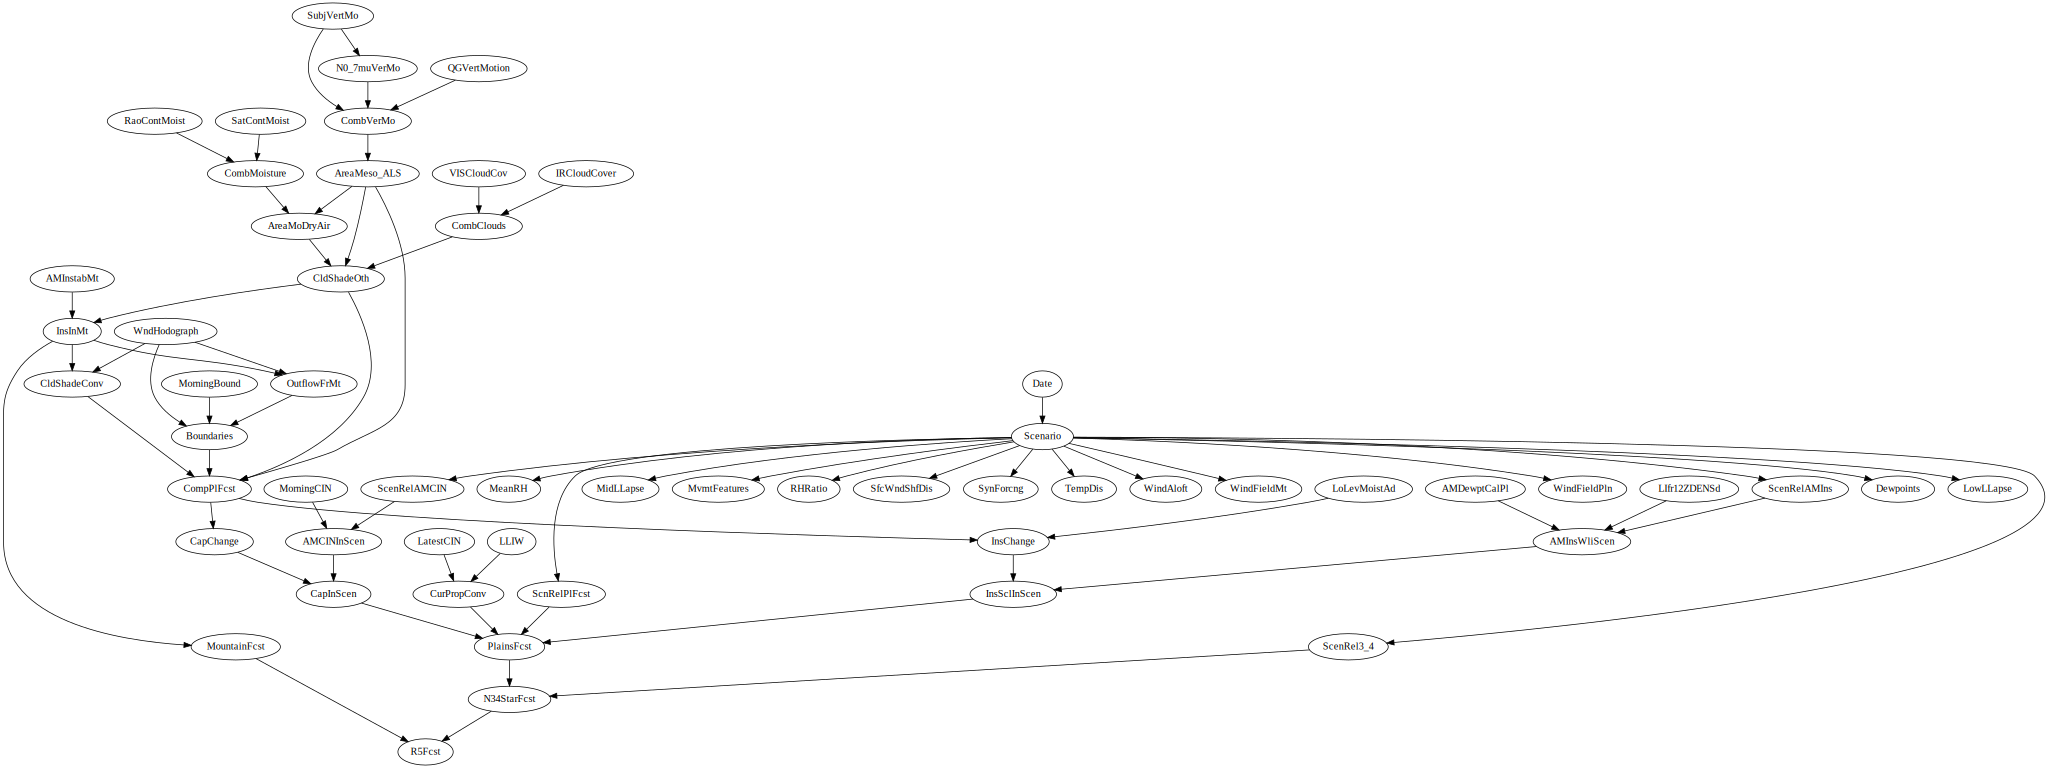

In [105]:
bn_large_hailfinder.graph

In [106]:
bn_large_hailfinder.remove_edge(('SubjVertMo', 'N0_7muVerMo'), cpt_3)

In [107]:
# bn_medium_child.graph

### task 1.3 specify probabilities for a node

In [108]:
bn_large_hailfinder.cpts.print_factor('Date')

| Date        |       Pr |
|-------------+----------|
| May15_Jun14 | 0.254098 |
| Jun15_Jul1  | 0.131148 |
| Jul2_Jul15  | 0.106557 |
| Jul16_Aug10 | 0.213115 |
| Aug11_Aug20 | 0.07377  |
| Aug20_Sep15 | 0.221312 |



### task 1.4 Save Bayesian network to a file

In [109]:
bn_large_hailfinder.save_to_file('large_hailfinder_copy')

### task 1.5 Load Baysian network from a file

In [110]:
Path_hailfinder_copy = "large_hailfinder_copy.net"
bn_L1_copy = BayesianNet(Path_hailfinder_copy)

In [111]:
bn_L1_copy.cpts.factors

{'N0_7muVerMo': {'dom': ['N0_7muVerMo', 'SubjVertMo'],
  'table': OrderedDict([(('StrongUp', 'StronUp'), '0.2'),
               (('WeakUp', 'StronUp'), '0.2'),
               (('Neutral', 'StronUp'), '0.2'),
               (('Down', 'StronUp'), '0.7'),
               (('StrongUp', 'WeakUp'), '0.7'),
               (('WeakUp', 'WeakUp'), '0.7'),
               (('Neutral', 'WeakUp'), '0.10'),
               (('Down', 'WeakUp'), '0.10'),
               (('StrongUp', 'Neutral'), '0.45'),
               (('WeakUp', 'Neutral'), '0.35'),
               (('Neutral', 'Neutral'), '0.35'),
               (('Down', 'Neutral'), '0.35'),
               (('StrongUp', 'Down'), '0.35'),
               (('WeakUp', 'Down'), '0.35'),
               (('Neutral', 'Down'), '0.35'),
               (('Down', 'Down'), '0.45')])},
 'SubjVertMo': {'dom': ['SubjVertMo'],
  'table': OrderedDict([(('StronUp',), '0.15'),
               (('WeakUp',), '0.15'),
               (('Neutral',), '0.50'),
               (('D

### Task2.1 Network pruning techniques based on query struture. These techniques are composed of edge and node pruning

In [112]:
bn_large_hailfinder_pruning = bn_large_hailfinder.pruning_net({'SubjVertMo'},{'RaoContMoist':'Wet'})

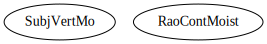

In [113]:
bn_large_hailfinder_pruning.graph

In [114]:
bn_large_hailfinder_pruning.cpts

SubjVertMo :
| SubjVertMo   |   Pr |
|--------------+------|
| StronUp      | 0.15 |
| WeakUp       | 0.15 |
| Neutral      | 0.5  |
| Down         | 0.2  |

RaoContMoist :
| RaoContMoist   |   Pr |
|----------------+------|
| VeryWet        | 0.15 |
| Wet            | 0.2  |
| Neutral        | 0.4  |
| Dry            | 0.25 |

### Task2.2 Min-fill heuristic for variable order elimination. Deterministic and stochastic composition of min-fill heuristic with min-degree heuristic

#### MinDegree

In [115]:
min_degree = MinDegree(bn_large_hailfinder)
min_degree.get_elimination_order()

['Date',
 'Dewpoints',
 'LowLLapse',
 'MeanRH',
 'MidLLapse',
 'MvmtFeatures',
 'RHRatio',
 'SfcWndShfDis',
 'SynForcng',
 'TempDis',
 'WindAloft',
 'WindFieldMt',
 'WindFieldPln',
 'SatContMoist',
 'RaoContMoist',
 'CombMoisture',
 'VISCloudCov',
 'IRCloudCover',
 'AMInstabMt',
 'LoLevMoistAd',
 'MorningCIN',
 'ScenRelAMCIN',
 'LatestCIN',
 'LLIW',
 'R5Fcst',
 'MountainFcst',
 'N0_7muVerMo',
 'SubjVertMo',
 'QGVertMotion',
 'CombVerMo',
 'AreaMoDryAir',
 'CombClouds',
 'MorningBound',
 'OutflowFrMt',
 'WndHodograph',
 'CapChange',
 'InsChange',
 'AMCINInScen',
 'LIfr12ZDENSd',
 'AMDewptCalPl',
 'ScenRelAMIns',
 'AMInsWliScen',
 'ScenRel3_4',
 'N34StarFcst',
 'AreaMeso_ALS',
 'CldShadeOth',
 'Boundaries',
 'CldShadeConv',
 'InsInMt',
 'CompPlFcst',
 'Scenario',
 'CapInScen',
 'InsSclInScen',
 'CurPropConv',
 'ScnRelPlFcst',
 'PlainsFcst']

#### MinFill

In [116]:
min_fill = MinFill(bn_large_hailfinder)
min_fill.get_elimination_order()

['N0_7muVerMo',
 'SubjVertMo',
 'QGVertMotion',
 'CombVerMo',
 'AreaMeso_ALS',
 'SatContMoist',
 'RaoContMoist',
 'CombMoisture',
 'AreaMoDryAir',
 'VISCloudCov',
 'IRCloudCover',
 'CombClouds',
 'CldShadeOth',
 'AMInstabMt',
 'InsInMt',
 'WndHodograph',
 'OutflowFrMt',
 'MorningBound',
 'Boundaries',
 'CldShadeConv',
 'CompPlFcst',
 'CapChange',
 'LoLevMoistAd',
 'InsChange',
 'MountainFcst',
 'Date',
 'Scenario',
 'ScenRelAMCIN',
 'MorningCIN',
 'AMCINInScen',
 'CapInScen',
 'ScenRelAMIns',
 'LIfr12ZDENSd',
 'AMDewptCalPl',
 'AMInsWliScen',
 'InsSclInScen',
 'ScenRel3_4',
 'LatestCIN',
 'LLIW',
 'CurPropConv',
 'ScnRelPlFcst',
 'PlainsFcst',
 'N34StarFcst',
 'R5Fcst',
 'Dewpoints',
 'LowLLapse',
 'MeanRH',
 'MidLLapse',
 'MvmtFeatures',
 'RHRatio',
 'SfcWndShfDis',
 'SynForcng',
 'TempDis',
 'WindAloft',
 'WindFieldMt',
 'WindFieldPln']

#### Min_degree Min_Fill

In [117]:
min_degree_min_fill = MinFill_MinDegree(bn_large_hailfinder)
min_degree_min_fill.get_elimination_order()

['Date',
 'Dewpoints',
 'LowLLapse',
 'MeanRH',
 'MidLLapse',
 'MvmtFeatures',
 'RHRatio',
 'SfcWndShfDis',
 'SynForcng',
 'TempDis',
 'WindAloft',
 'WindFieldMt',
 'WindFieldPln',
 'SatContMoist',
 'RaoContMoist',
 'CombMoisture',
 'VISCloudCov',
 'IRCloudCover',
 'AMInstabMt',
 'LoLevMoistAd',
 'MorningCIN',
 'LatestCIN',
 'LLIW',
 'R5Fcst',
 'N0_7muVerMo',
 'SubjVertMo',
 'QGVertMotion',
 'CombVerMo',
 'AreaMoDryAir',
 'CombClouds',
 'MorningBound',
 'LIfr12ZDENSd',
 'AMDewptCalPl',
 'AreaMeso_ALS',
 'CurPropConv',
 'MountainFcst',
 'ScenRelAMCIN',
 'ScenRelAMIns',
 'OutflowFrMt',
 'WndHodograph',
 'CldShadeOth',
 'Boundaries',
 'CldShadeConv',
 'InsInMt',
 'CapChange',
 'InsChange',
 'AMCINInScen',
 'AMInsWliScen',
 'ScnRelPlFcst',
 'ScenRel3_4',
 'N34StarFcst',
 'CompPlFcst',
 'Scenario',
 'CapInScen',
 'InsSclInScen',
 'PlainsFcst']

## task 3.1 jointree be speciﬁed by the user

In [118]:
order = ['Date',
 'Dewpoints',
 'LowLLapse',
 'MeanRH',
 'MidLLapse',
 'MvmtFeatures',
 'RHRatio',
 'SfcWndShfDis',
 'SynForcng',
 'TempDis',
 'WindAloft',
 'WindFieldMt',
 'WindFieldPln',
 'SatContMoist',
 'RaoContMoist',
 'CombMoisture',
 'VISCloudCov',
 'IRCloudCover',
 'AMInstabMt',
 'LoLevMoistAd',
 'MorningCIN',
 'ScenRelAMCIN',
 'LatestCIN',
 'LLIW',
 'R5Fcst',
 'MountainFcst',
 'N0_7muVerMo',
 'SubjVertMo',
 'QGVertMotion',
 'CombVerMo',
 'AreaMoDryAir',
 'CombClouds',
 'MorningBound',
 'OutflowFrMt',
 'WndHodograph',
 'CapChange',
 'InsChange',
 'AMCINInScen',
 'LIfr12ZDENSd',
 'AMDewptCalPl',
 'ScenRelAMIns',
 'AMInsWliScen',
 'ScenRel3_4',
 'N34StarFcst',
 'AreaMeso_ALS',
 'CldShadeOth',
 'Boundaries',
 'CldShadeConv',
 'InsInMt',
 'CompPlFcst',
 'Scenario',
 'CapInScen',
 'InsSclInScen',
 'CurPropConv',
 'ScnRelPlFcst',
 'PlainsFcst']

In [119]:
hailfinder_jointree = bn_large_hailfinder.to_jointree(order)

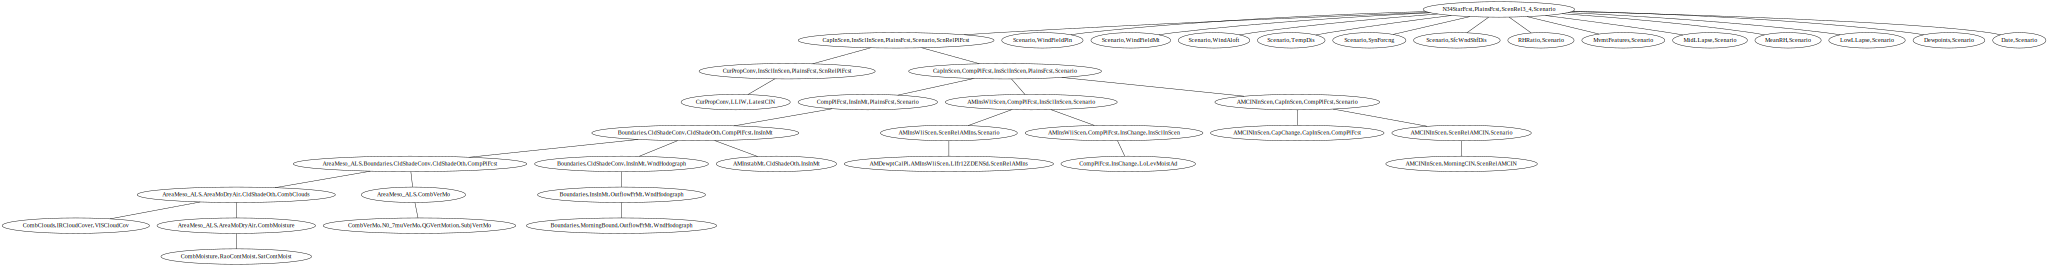

In [120]:
hailfinder_jointree.cluster_graph

## task 3.2 jointree given order

In [121]:
min_degree_min_fill = MinFill_MinDegree(bn_large_hailfinder)
order = min_degree_min_fill.get_elimination_order()

In [122]:
hailfinder_jointree = bn_large_hailfinder.to_jointree(order)

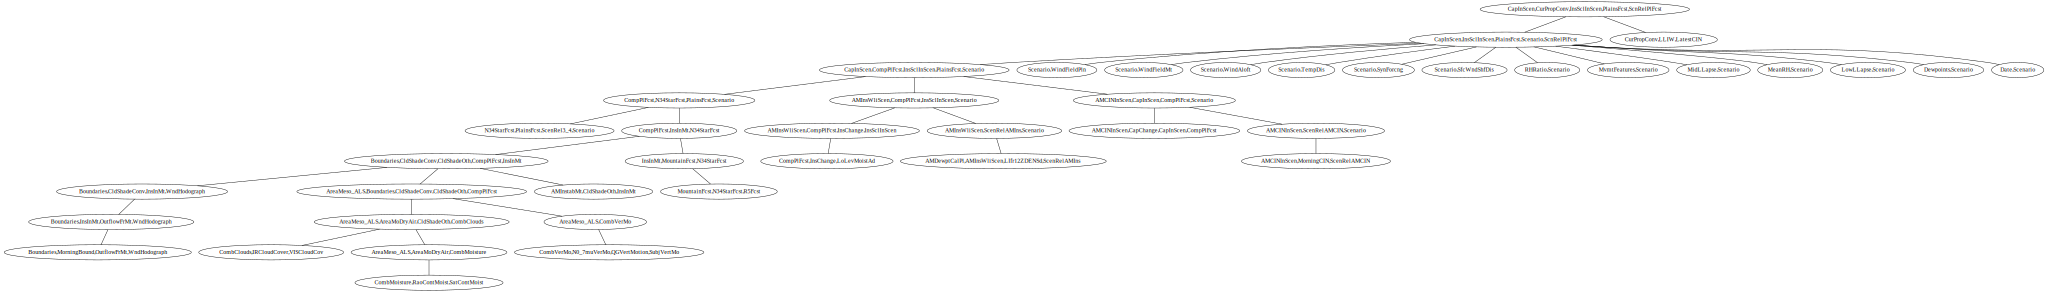

In [123]:
hailfinder_jointree.cluster_graph

In [124]:
hailfinder_jointree.factors

('Date', 'Scenario') :
| Date        | Scenario   |         Pr |
|-------------+------------+------------|
| May15_Jun14 | A          | 0.0254098  |
| May15_Jun14 | B          | 0.0406557  |
| May15_Jun14 | C          | 0.0254098  |
| May15_Jun14 | D          | 0.0203278  |
| May15_Jun14 | E          | 0.0203278  |
| May15_Jun14 | F          | 0.00254098 |
| May15_Jun14 | G          | 0.0203278  |
| May15_Jun14 | H          | 0.0254098  |
| May15_Jun14 | I          | 0.0228688  |
| May15_Jun14 | J          | 0.00762294 |
| May15_Jun14 | K          | 0.0431967  |
| Jun15_Jul1  | A          | 0.0065574  |
| Jun15_Jul1  | B          | 0.0209837  |
| Jun15_Jul1  | C          | 0.0118033  |
| Jun15_Jul1  | D          | 0.0118033  |
| Jun15_Jul1  | E          | 0.0157378  |
| Jun15_Jul1  | F          | 0.00262296 |
| Jun15_Jul1  | G          | 0.0170492  |
| Jun15_Jul1  | H          | 0.00786888 |
| Jun15_Jul1  | I          | 0.00918036 |
| Jun15_Jul1  | J          | 0.0144263  |
| Jun15_Jul

# task 3.3 A function to set evidence

### Steps to query:
1. uses **xjointree.evidence()** funtion
2. uses **xjointree.get_message()** function
3. uses **xjointree.cluster_query()**
  
p.s. If you want to start a new query, use **xjointree.query_clear()** to clear the message and follow the steps again

In [125]:
hailfinder_jointree.evidence({'Date':'Jun15_Jul1'})

{'Date': {'dom': ('Date',),
  'table': OrderedDict([(('May15_Jun14',), 0),
               (('Jun15_Jul1',), 1),
               (('Jul2_Jul15',), 0),
               (('Jul16_Aug10',), 0),
               (('Aug11_Aug20',), 0),
               (('Aug20_Sep15',), 0)])}}

In [126]:
hailfinder_jointree.display_evidence()

| Date        |   Pr |
|-------------+------|
| May15_Jun14 |    0 |
| Jun15_Jul1  |    1 |
| Jul2_Jul15  |    0 |
| Jul16_Aug10 |    0 |
| Aug11_Aug20 |    0 |
| Aug20_Sep15 |    0 |



# task 3.4  A function to answer a query based on the jointree clusters

In [127]:
hailfinder_jointree.get_message()

(('N34StarFcst', 'PlainsFcst', 'ScenRel3_4', 'Scenario'), ('CompPlFcst', 'N34StarFcst', 'PlainsFcst', 'Scenario')) :
| Scenario   | N34StarFcst   | PlainsFcst   |   Pr |
|------------+---------------+--------------+------|
| A          | XNIL          | XNIL         | 0.94 |
| A          | XNIL          | SIG          | 0.06 |
| A          | XNIL          | SVR          | 0.01 |
| A          | SIG           | XNIL         | 0.05 |
| A          | SIG           | SIG          | 0.89 |
| A          | SIG           | SVR          | 0.05 |
| A          | SVR           | XNIL         | 0.01 |
| A          | SVR           | SIG          | 0.05 |
| A          | SVR           | SVR          | 0.94 |
| B          | XNIL          | XNIL         | 0.98 |
| B          | XNIL          | SIG          | 0.04 |
| B          | XNIL          | SVR          | 0    |
| B          | SIG           | XNIL         | 0.02 |
| B          | SIG           | SIG          | 0.94 |
| B          | SIG           | SVR 

In [128]:
hailfinder_jointree.clusters_query({'WndHodograph'})

{'dom': ('WndHodograph',),
 'table': OrderedDict([(('DCVZFavor',), '0.3'),
              (('StrongWest',), '0.24999999999999997'),
              (('Westerly',), '0.24999999999999997'),
              (('Other',), '0.19999999999999996')])}

In [129]:
# uses hailfinder_jointree.query_clear() to start a new query

# task 3.5 four jointree functions

## Add a variable to a cluster

In [130]:
hailfinder_jointree.add_a_variable(('N0_7muVerMo',),Cluster(('AreaMeso_ALS','CombVerMo')))

In [131]:
hailfinder_jointree.factors[Cluster(('AreaMeso_ALS','CombVerMo','N0_7muVerMo'))]

{'dom': ('AreaMeso_ALS', 'CombVerMo'),
 'table': OrderedDict([(('StrongUp', 'StrongUp'), 1.0),
              (('StrongUp', 'WeakUp'), 0.0),
              (('StrongUp', 'Neutral'), 0.0),
              (('StrongUp', 'Down'), 0.0),
              (('WeakUp', 'StrongUp'), 0.0),
              (('WeakUp', 'WeakUp'), 1.0),
              (('WeakUp', 'Neutral'), 0.0),
              (('WeakUp', 'Down'), 0.0),
              (('Neutral', 'StrongUp'), 0.0),
              (('Neutral', 'WeakUp'), 0.0),
              (('Neutral', 'Neutral'), 1.0),
              (('Neutral', 'Down'), 0.0),
              (('Down', 'StrongUp'), 0.0),
              (('Down', 'WeakUp'), 0.0),
              (('Down', 'Neutral'), 0.0),
              (('Down', 'Down'), 1.0)])}

## Merge Clusters

In [132]:
hailfinder_jointree.merge_clusters(Cluster(('MountainFcst','N34StarFcst','R5Fcst')),Cluster(('InsInMt','MountainFcst','N34StarFcst')))

In [133]:
hailfinder_jointree.factors[Cluster(('InsInMt','MountainFcst','N34StarFcst','R5Fcst'))]

{'dom': ('R5Fcst', 'MountainFcst', 'N34StarFcst', 'InsInMt'),
 'table': OrderedDict([(('XNIL', 'XNIL', 'XNIL', 'None'), 1.0),
              (('XNIL', 'XNIL', 'XNIL', 'Weak'), 0.48),
              (('XNIL', 'XNIL', 'XNIL', 'Strong'), 0.2),
              (('XNIL', 'XNIL', 'SIG', 'None'), 0.0),
              (('XNIL', 'XNIL', 'SIG', 'Weak'), 0.0),
              (('XNIL', 'XNIL', 'SIG', 'Strong'), 0.0),
              (('XNIL', 'XNIL', 'SVR', 'None'), 0.0),
              (('XNIL', 'XNIL', 'SVR', 'Weak'), 0.0),
              (('XNIL', 'XNIL', 'SVR', 'Strong'), 0.0),
              (('XNIL', 'SIG', 'XNIL', 'None'), 0.0),
              (('XNIL', 'SIG', 'XNIL', 'Weak'), 0.0),
              (('XNIL', 'SIG', 'XNIL', 'Strong'), 0.0),
              (('XNIL', 'SIG', 'SIG', 'None'), 0.0),
              (('XNIL', 'SIG', 'SIG', 'Weak'), 0.0),
              (('XNIL', 'SIG', 'SIG', 'Strong'), 0.0),
              (('XNIL', 'SIG', 'SVR', 'None'), 0.0),
              (('XNIL', 'SIG', 'SVR', 'Weak'), 0.0),
  

## Add Cluster

In [134]:
hailfinder_jointree.add_a_cluster(Cluster(('Scenario',)),Cluster(('MvmtFeatures','Scenario')))

In [135]:
hailfinder_jointree.factors[Cluster(('Scenario',))]

{'dom': (), 'table': OrderedDict()}

## Remove Cluster

In [136]:
hailfinder_jointree.remove_a_cluster(Cluster(('Grunting',)))

# task 4 Gibbs sampling

In [137]:
bn_large_hailfinder = BayesianNet('hailfinder.net')
gibbs = GibbsSampling(bn_large_hailfinder)

In [138]:
gibbs.factors

N0_7muVerMo :
| N0_7muVerMo   |   Pr |
|---------------+------|
| StrongUp      | 0.25 |
| WeakUp        | 0.25 |
| Neutral       | 0.25 |
| Down          | 0.25 |

SubjVertMo :
| SubjVertMo   |   Pr |
|--------------+------|
| StronUp      | 0.15 |
| WeakUp       | 0.15 |
| Neutral      | 0.5  |
| Down         | 0.2  |

QGVertMotion :
| QGVertMotion   |   Pr |
|----------------+------|
| StrongUp       | 0.15 |
| WeakUp         | 0.15 |
| Neutral        | 0.5  |
| Down           | 0.2  |

CombVerMo :
| CombVerMo   | N0_7muVerMo   | SubjVertMo   | QGVertMotion   |   Pr |
|-------------+---------------+--------------+----------------+------|
| StrongUp    | StrongUp      | StronUp      | StrongUp       | 1    |
| WeakUp      | StrongUp      | StronUp      | StrongUp       | 0    |
| Neutral     | StrongUp      | StronUp      | StrongUp       | 0    |
| Down        | StrongUp      | StronUp      | StrongUp       | 0    |
| StrongUp    | StrongUp      | StronUp      | WeakUp         | 0.9